# ----- GROUP 9 BANKRUPTCY  PREPROCESSING  ----- #

1. Defining Functions

In [1]:
#!pip install tensorflow
#!pip install keras
#!pip install XGBoost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import itertools
from scipy.io import arff
from IPython.display import display
import seaborn as sns

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import sklearn
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import KBinsDiscretizer
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm

Using TensorFlow backend.


In [3]:
#load the arff files
def arfftodf(filename):
    #path = ""
    year = arff.loadarff(filename)[0]
    year = pd.DataFrame(year)
    year_org = year.copy()
    return year

In [4]:
# decode the values of class column using utf-8
def decodeclass(file):
    file["class"] = file["class"].apply(lambda x: x.decode("utf-8"))
    return file

In [5]:
#Replace missing values in training set
def replacemissingtrain(filename):
    filename_org = filename.copy()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp =imp.fit(filename)
    filename = imp.transform(filename)
    return filename

In [6]:
#Replace missing values
def replacemissingtest(filename, train):
    filename_np = np.array(filename)
    train2 = np.array(train)
    N = len(filename_np)
    D = 64
    ttrain = np.nanmean(train2, axis=0)
    for n in range(N):
        for d in range(D):
            if np.isnan(filename_np[n][d])== True:
                filename_np[n][d] = ttrain[d]
    return filename_np

In [7]:
#Divide features and class, create train/test split
def featuresnclass(filename, testsize):
    classification = filename["class"]
    features = filename.drop(columns="class")
    data_train, data_test, target_train, target_test = train_test_split(features, classification, test_size=testsize, random_state=42, stratify=classification)
    return data_train, data_test, target_train, target_test

In [8]:
# Function for Confusion Matrix as provided in tutorial
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_attr_hist(data, nrows:int, ncols:int, log:bool=False, bins:int=100):
    plt.figure(figsize=(ncols*5, nrows*5))
    for i in range (len(data.columns)):
        plt.subplot(nrows, ncols, i+1)
        plt.title(data.columns[i])
        plt.hist(data.values[:, i], log=log, bins=bins)
    plt.show()

In [10]:
def plot_attr_box(data_feature, data_class, nrows:int, ncols:int):
    plt.figure(figsize=(ncols*5, nrows*5))
    for i in range (len(data_feature.columns)):
        plt.subplot(nrows, ncols, i+1)
        plt.title(data_feature.columns[i])
        sns.boxplot(x=data_class, y=data_feature.values[:, i])
    plt.tight_layout()
    plt.show()

In [11]:
#show correlation (2 options)
def show_correlations(dataset):
    display(dataset.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2))
    plt.matshow(dataset.corr())
    plt.title('Matshow correlation')
    plt.show()
    
def show_correlations_large(dataset):
    f = plt.figure(figsize=(19, 15))
    df = dataset
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

In [12]:
# create decision tree and random forest
def create_dc_rf(trainset, trainlabels, type='rf'):  
    if type == "rf":
        # Instantiate model with 1000 decision trees
        model = RandomForestClassifier(n_estimators = 100, random_state = 42)
    elif type == "dc":
        # Instantiate decision tree
        model = DecisionTreeClassifier()
    # Train the model on training data
    model.fit(trainset, trainlabels);
    return model

In [13]:
# find important features  
def get_important_features(model, trainset):
    importance = model.feature_importances_
    return importance

In [14]:
# remove features below importance threshold
def remove_unimportant_features(model, trainset, testset, threshold = 0.03):
    importance = model.feature_importances_
    i = 0
    trainset2 = trainset.copy()
    testset2 = testset.copy()
    for x, y in trainset2.iteritems():
        if importance[i] <= threshold:
            trainset2.drop([x], axis=1, inplace=True)
            testset2.drop([x], axis=1, inplace=True)
        i+=1 
    return trainset2, testset2

In [15]:
# remove features correlated to important features   
def remove_correlations_important_features(model, trainset, testset, num_features = 10, threshold = 0.5):
    importance_list = get_important_features(model, trainset)
    indices = np.argpartition(importance_list, -num_features)[-num_features:]
    print("The {} most important features are: {}".format(num_features, indices))
    trainset2 = trainset.copy()
    testset2 = testset.copy()
    correlation_matrix = trainset.corr()
    correlated_features = set()
    important_features = set()
    for ind in indices:
        important_features.add(correlation_matrix.columns[ind])
        for i in range(len(correlation_matrix)):
            if abs(correlation_matrix.iloc[i, ind]) >= threshold and i != ind:
                
                colname = correlation_matrix.columns[i]
                if colname not in important_features:
                    correlated_features.add(colname)
                
    print('remove ', correlated_features)
    print('important ', important_features)            
    trainset2.drop(correlated_features, axis=1, inplace = True)
    testset2.drop(correlated_features, axis=1, inplace = True)                 
    return trainset2, testset2

In [16]:
#F2 #Score
def getf2(test, prediction):
    f2 = ((1 + 2**2)*sklearn.metrics.precision_score(test, prediction, pos_label="1") * sklearn.metrics.recall_score(test, prediction, pos_label="1") / (2**2 * sklearn.metrics.precision_score(test, prediction, pos_label="1") + sklearn.metrics.recall_score(test, prediction, pos_label="1")))
    return f2

2. Loading the data

In [17]:
# First year - load data
firstyear_miss = arfftodf("1year.arff")
firstyear = decodeclass(firstyear_miss)
firstyearfeat_train_raw, firstyearfeat_test_raw, firstyearclass_train, firstyearclass_test = featuresnclass(firstyear, 0.15)

# replace missing values
firstyearfeat_train = replacemissingtrain(firstyearfeat_train_raw)
firstyearfeat_test = replacemissingtest(firstyearfeat_test_raw, firstyearfeat_train_raw)

#normalized the data using standard scaling (z-score)
scaler = preprocessing.StandardScaler()
firstyearfeat_train = scaler.fit_transform(firstyearfeat_train)
firstyearfeat_test = scaler.transform(firstyearfeat_test)

# create pandas Dataframe
firstyearfeat_train = pd.DataFrame(firstyearfeat_train, columns = firstyearfeat_train_raw.columns)
firstyearfeat_test = pd.DataFrame(firstyearfeat_test, columns = firstyearfeat_train_raw.columns)

In [18]:
# Second year - load data
secondyear_miss = arfftodf("2year.arff")
secondyear = decodeclass(secondyear_miss)
secondyearfeat_train_raw, secondyearfeat_test_raw, secondyearclass_train, secondyearclass_test = featuresnclass(secondyear, 0.15)

# replace missing values
secondyearfeat_train = replacemissingtrain(secondyearfeat_train_raw)
secondyearfeat_test = replacemissingtest(secondyearfeat_test_raw, secondyearfeat_train_raw)

#normalized the data using standard scaling (z-score)
scaler = preprocessing.StandardScaler()
secondyearfeat_train = scaler.fit_transform(secondyearfeat_train)
secondyearfeat_test = scaler.transform(secondyearfeat_test)

# create pandas Dataframe
secondyearfeat_train = pd.DataFrame(secondyearfeat_train, columns = secondyearfeat_train_raw.columns)
secondyearfeat_test = pd.DataFrame(secondyearfeat_test, columns = secondyearfeat_train_raw.columns)

In [19]:
# Third year - load data
thirdyear_miss = arfftodf("3year.arff")
thirdyear = decodeclass(thirdyear_miss)
thirdyearfeat_train_raw, thirdyearfeat_test_raw, thirdyearclass_train, thirdyearclass_test = featuresnclass(thirdyear, 0.15)

# replace missing values
thirdyearfeat_train = replacemissingtrain(thirdyearfeat_train_raw)
thirdyearfeat_test = replacemissingtest(thirdyearfeat_test_raw, thirdyearfeat_train_raw)

#normalized the data using standard scaling (z-score)
scaler = preprocessing.StandardScaler()
thirdyearfeat_train = scaler.fit_transform(thirdyearfeat_train)
thirdyearfeat_test = scaler.transform(thirdyearfeat_test)


# create pandas Dataframe
thirdyearfeat_train = pd.DataFrame(thirdyearfeat_train, columns = thirdyearfeat_train_raw.columns)
thirdyearfeat_test = pd.DataFrame(thirdyearfeat_test, columns = thirdyearfeat_train_raw.columns)

In [20]:
# Fourth year - load data
fourthyear_miss = arfftodf("4year.arff")
fourthyear = decodeclass(fourthyear_miss)
fourthyearfeat_train_raw, fourthyearfeat_test_raw, fourthyearclass_train, fourthyearclass_test = featuresnclass(fourthyear, 0.15)

# replace missing values
fourthyearfeat_train = replacemissingtrain(fourthyearfeat_train_raw)
fourthyearfeat_test = replacemissingtest(fourthyearfeat_test_raw, fourthyearfeat_train_raw)

#normalized the data using standard scaling (z-score)
scaler = preprocessing.StandardScaler()
fourthyearfeat_train = scaler.fit_transform(fourthyearfeat_train)
fourthyearfeat_test = scaler.transform(fourthyearfeat_test)

# create pandas Dataframe
fourthyearfeat_train = pd.DataFrame(fourthyearfeat_train, columns = fourthyearfeat_train_raw.columns)
fourthyearfeat_test = pd.DataFrame(fourthyearfeat_test, columns = fourthyearfeat_train_raw.columns)

In [21]:
# Fifth year - load data
fifthyear_miss = arfftodf("5year.arff")
fifthyear = decodeclass(fifthyear_miss)
fifthyearfeat_train_raw, fifthyearfeat_test_raw, fifthyearclass_train, fifthyearclass_test = featuresnclass(fifthyear, 0.15)

# replace missing values
fifthyearfeat_train = replacemissingtrain(fifthyearfeat_train_raw)
fifthyearfeat_test = replacemissingtest(fifthyearfeat_test_raw, fifthyearfeat_train_raw)

#normalized the data using standard scaling (z-score)
scaler = preprocessing.StandardScaler()
fifthyearfeat_train = scaler.fit_transform(fifthyearfeat_train)
fifthyearfeat_test = scaler.transform(fifthyearfeat_test)

# create pandas Dataframe
fifthyearfeat_train = pd.DataFrame(fifthyearfeat_train, columns = fifthyearfeat_train_raw.columns)
fifthyearfeat_test = pd.DataFrame(fifthyearfeat_test, columns = fifthyearfeat_train_raw.columns)

# Data Understanding

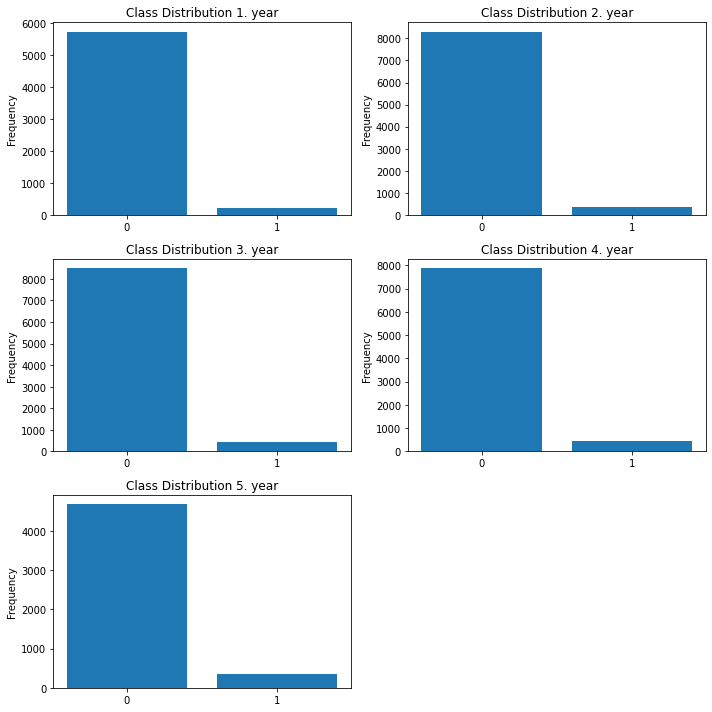

In [22]:
#Data Understanding: What is the distribution of labels / target variable?
plt.figure(figsize=(10,10))
all_years_class_train = [firstyearclass_train,secondyearclass_train,thirdyearclass_train,fourthyearclass_train,fifthyearclass_train]
t=1

# iterate over all values that we want to test for K
for i in all_years_class_train:
    # add a subplot
    plt.subplot(3,2,t)
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # plot class distribution
    class_dist = pd.Series(i).value_counts()
    plt.bar(class_dist.index, class_dist)
    plt.xticks([0,1])
    plt.ylabel("Frequency")
    plt.title("Class Distribution {}. year".format(t))
    t +=1
        
plt.show()

In [23]:
# Data Understanding: Are all attributes and their types listed?

#firstyearfeat_train.info()
#secondyearfeat_train.info()
thirdyearfeat_train.info()
#fourthyearfeat_train.info()
#fifthyearfeat_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8927 entries, 0 to 8926
Data columns (total 64 columns):
Attr1     8927 non-null float64
Attr2     8927 non-null float64
Attr3     8927 non-null float64
Attr4     8927 non-null float64
Attr5     8927 non-null float64
Attr6     8927 non-null float64
Attr7     8927 non-null float64
Attr8     8927 non-null float64
Attr9     8927 non-null float64
Attr10    8927 non-null float64
Attr11    8927 non-null float64
Attr12    8927 non-null float64
Attr13    8927 non-null float64
Attr14    8927 non-null float64
Attr15    8927 non-null float64
Attr16    8927 non-null float64
Attr17    8927 non-null float64
Attr18    8927 non-null float64
Attr19    8927 non-null float64
Attr20    8927 non-null float64
Attr21    8927 non-null float64
Attr22    8927 non-null float64
Attr23    8927 non-null float64
Attr24    8927 non-null float64
Attr25    8927 non-null float64
Attr26    8927 non-null float64
Attr27    8927 non-null float64
Attr28    8927 non-null float

In [24]:
#Data Understanding: What is the quality of the data?
# % NA values for each data set
a = firstyearfeat_train_raw.isna().sum()
print(f"First year: {sum(a)/(len(firstyearfeat_train)*64)}")
b = (secondyearfeat_train_raw.isna().sum())
print(f"Second year: {sum(b)/(len(secondyearfeat_train)*64)}")
c = (thirdyearfeat_train_raw.isna().sum())
print(f"Third year: {sum(c)/(len(thirdyearfeat_train)*64)}")
d=(fourthyearfeat_train_raw.isna().sum())
print(f"Fourth year: {sum(d)/(len(fourthyearfeat_train)*64)}")
e=(fifthyearfeat_train_raw.isna().sum())
print(f"Fifth year: {sum(e)/(len(fifthyearfeat_train)*64)}")
len(thirdyearfeat_train)

First year: 0.01297722705961152
Second year: 0.01863363016074939
Third year: 0.014630825025204436
Fourth year: 0.013899735672233569
Fifth year: 0.012420988453115667


8927

In [25]:
# Descriptive statistics for training dataset and training targets
print("Train Set Labels:")
print(thirdyearclass_train.describe())
print("")
print("Train Set Features:")
thirdyearfeat_train_raw.describe()

Train Set Labels:
count     8927
unique       2
top          0
freq      8506
Name: class, dtype: object

Train Set Features:


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,8927.000000,8927.000000,8927.000000,8913.000000,8.907000e+03,8927.000000,8927.000000,8916.000000,8924.000000,8927.000000,...,8.927000e+03,8891.000000,8927.000000,8903.000000,8927.000000,8.427000e+03,8911.000000,8.891000e+03,8913.000000,8737.000000
mean,0.054403,0.638120,0.079644,10.949588,-1.665045e+03,-0.139771,0.067038,18.301023,1.821019,0.348283,...,6.341261e+03,-0.633396,0.025047,3.909328,1.619297,6.042683e+02,14.426104,1.376769e+02,9.245834,37.019120
std,0.691610,6.968054,6.960541,567.877428,1.283950e+05,7.556822,0.694796,712.210972,8.160769,6.969727,...,5.633136e+04,60.716368,19.888696,201.795747,83.812580,4.012859e+04,90.243293,2.819044e+04,33.381492,447.572994
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000541,0.255210,0.016248,1.037600,-5.194450e+01,0.000000,0.001809,0.432663,1.009700,0.297340,...,1.312150e+01,0.004630,0.006719,0.876180,0.000000,5.546750e+00,4.495200,4.064500e+01,3.059500,2.003700
50%,0.042128,0.462700,0.198010,1.606100,1.809300e+00,0.000000,0.050097,1.112900,1.192600,0.515940,...,8.803700e+02,0.051303,0.103990,0.953360,0.002709,9.955400e+00,6.704100,7.035300e+01,5.158300,4.034100
75%,0.123285,0.689490,0.420335,2.959700,5.593250e+01,0.073158,0.140880,2.836175,2.051575,0.725580,...,4.256650e+03,0.129605,0.269630,0.996285,0.242230,2.101750e+01,10.650500,1.184300e+02,8.916300,9.664300
max,52.652000,480.730000,17.708000,53433.000000,6.837700e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000


In [26]:
# Descriptive statistics for test dataset and test targets
print("Test Set Labels:")
print(thirdyearclass_test.describe())
print("")
print("Test Set Features:")
print(thirdyearfeat_test_raw.describe())

Test Set Labels:
count     1576
unique       2
top          0
freq      1502
Name: class, dtype: object

Test Set Features:
             Attr1        Attr2        Attr3        Attr4          Attr5  \
count  1576.000000  1576.000000  1576.000000  1572.000000    1571.000000   
mean      0.044018     0.516772     0.185248     4.485915     451.781314   
std       0.295360     0.500071     0.497804    27.992962   17791.967696   
min      -5.352700     0.000000   -10.177000     0.006468  -96364.000000   
25%       0.002334     0.247885     0.025850     1.061900     -53.802000   
50%       0.047330     0.469240     0.202600     1.602650       0.418240   
75%       0.127575     0.688808     0.414845     2.950525      56.706000   
max       2.621600    10.455000     1.054600   886.690000  685440.000000   

             Attr6        Attr7         Attr8        Attr9       Attr10  ...  \
count  1576.000000  1576.000000   1573.000000  1576.000000  1576.000000  ...   
mean     -0.015736     0.057620

# Preprocessing

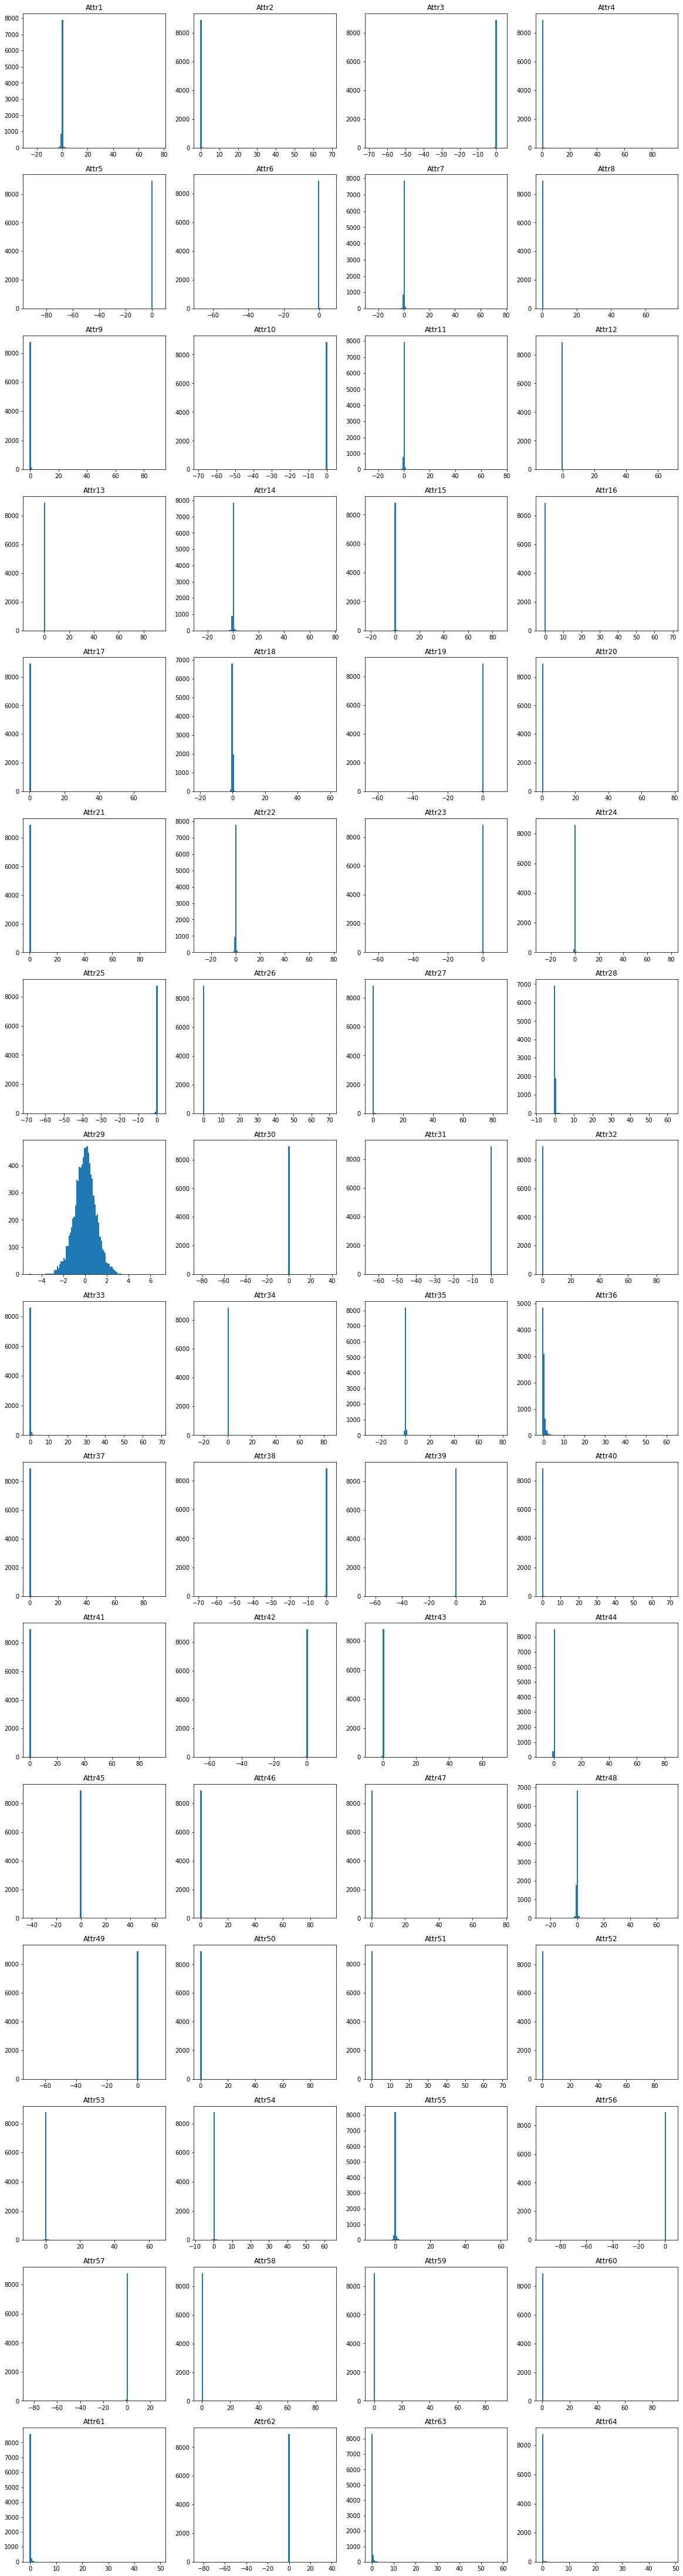

In [27]:
#Preprocessing: Checked for outliers (and handled them)? [Pratik]
plot_attr_hist(thirdyearfeat_train, nrows=18, ncols=4, log=False, bins=100)

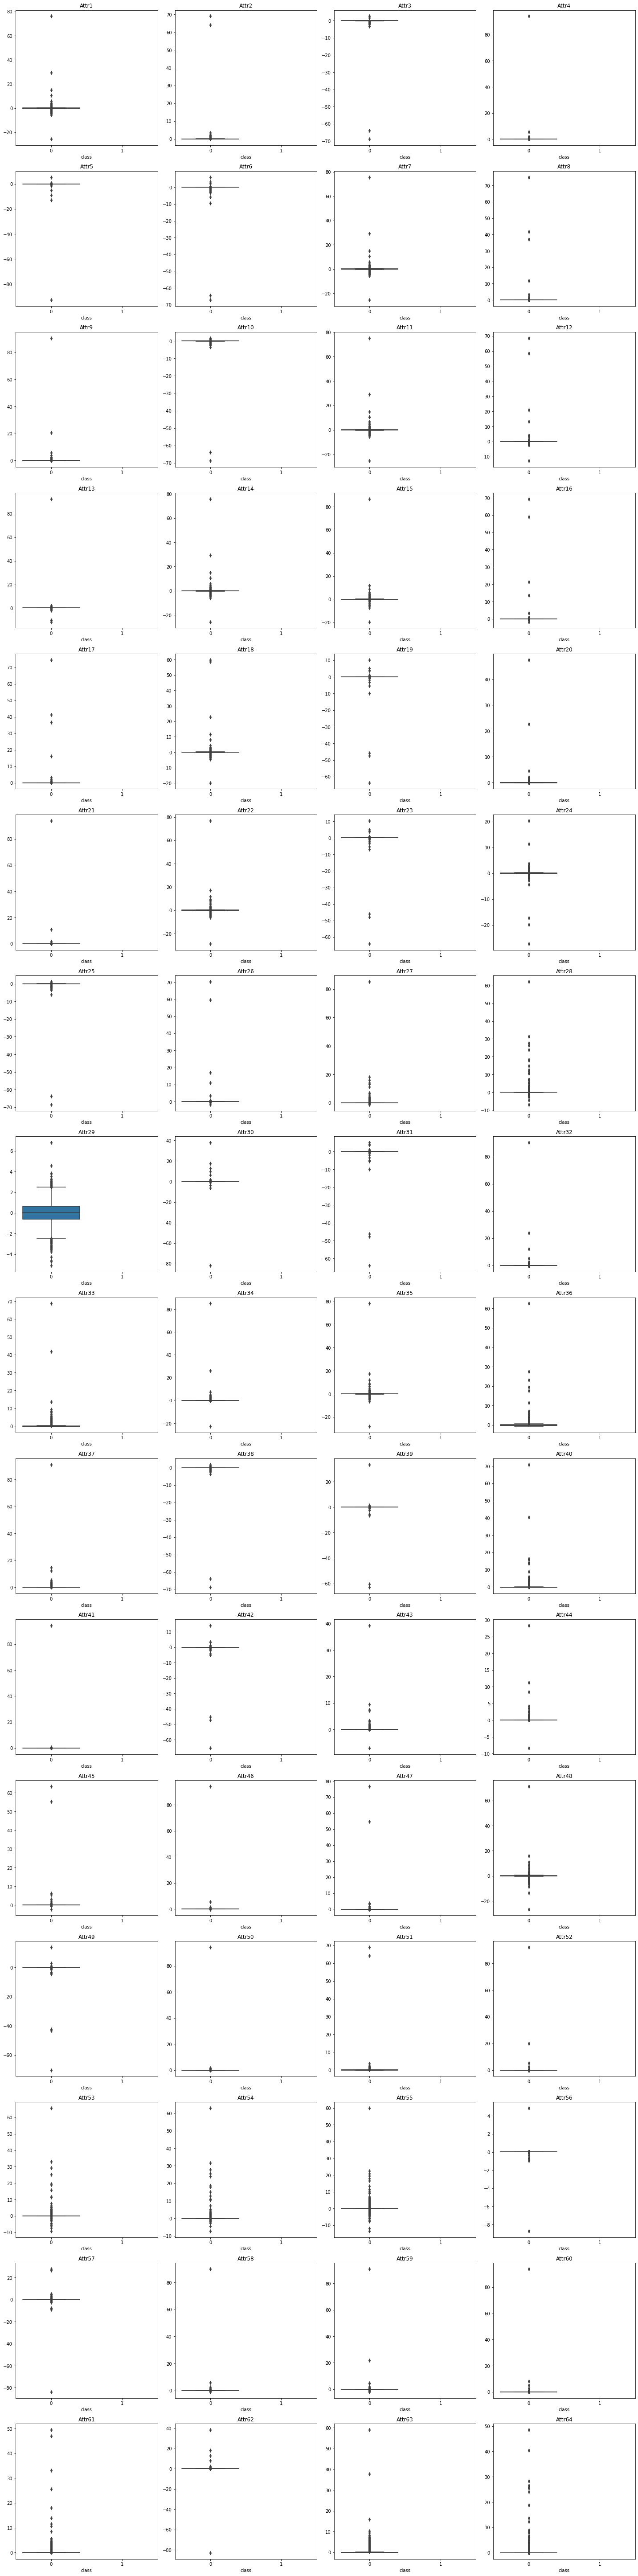

In [28]:
plot_attr_box(thirdyearfeat_train, thirdyearclass_train, nrows=18, ncols=4)

In [29]:
#outlier detection
outlier_detection = DBSCAN(min_samples = 2, eps = 3)
clusters = outlier_detection.fit_predict(thirdyearfeat_train)
list(clusters).count(-1)

156

In [30]:
# validity checks (w/ unnormalized data)
maxValues = thirdyearfeat_train_raw.max()
minValues = thirdyearfeat_train_raw.min() 
#X55 working capital
print(f"Working captital max: {maxValues[[54]]}")
print(f"Working captital min: {minValues[[54]]}")

#X27 profit on operating activities / financial expenses
print(f"Profit on operating activities / financial expenses max: {maxValues[[26]]}")
print(f"Profit on operating activities / financial expenses min: {minValues[[26]]}")

Working captital max: Attr55    3380500.0
dtype: float64
Working captital min: Attr55   -751380.0
dtype: float64
Profit on operating activities / financial expenses max: Attr27    2723000.0
dtype: float64
Profit on operating activities / financial expenses min: Attr27   -41119.0
dtype: float64


In [31]:
#check for inconsistencies (w/ unnormalized data)

#attribute 29: logarithm of total assets -> e^(attribute 29)= total assets
total_assets=np.exp((np.array(thirdyearfeat_train_raw).transpose())[28])
#X35 profit on sales / total assets
profit_on_sales=(((np.array(thirdyearfeat_train_raw).transpose())[34])*total_assets)
#X36 total sales / total assets
total_sales=(((np.array(thirdyearfeat_train_raw).transpose())[35])*total_assets)
#X18 gross profit / total assets
gross_profit=(((np.array(thirdyearfeat_train_raw).transpose())[17])*total_assets)
#X1 net profit / total assets
net_profit=(((np.array(thirdyearfeat_train_raw).transpose())[0])*total_assets)
#X7 EBIT / total assets
EBIT=(((np.array(thirdyearfeat_train_raw).transpose())[6])*total_assets)
#X14 (gross profit + interest) / total assets
gross_profit_interest=(((np.array(thirdyearfeat_train_raw).transpose())[13])*total_assets)
print(f"Total # of examples: {len(EBIT)}")

#Check 1: gross_profit > net_profit
inconsistencies = 0
for i in range(len(gross_profit)):
    if gross_profit[i]<net_profit[i]:
        inconsistencies +=1
print(f"Examples in which gross profit is smaller than net profit (abs.): {inconsistencies}")
print(f"Examples in which gross profit is smaller than net profit (%): {inconsistencies/(len(gross_profit))}")

#Check 2: gross_profit > EBIT
inconsistencies_2 = 0
for i in range(len(gross_profit)):
    if gross_profit[i]<EBIT[i]:
        inconsistencies_2 +=1
print(f"Examples in which gross profit is smaller than EBIT (abs.): {inconsistencies_2}")

#Check 3: gross_profit > gross_profit_interest
inconsistencies_3 = 0
for i in range(len(gross_profit)):
    if gross_profit[i]<gross_profit_interest[i]:
        inconsistencies_3 +=1
print(f"Examples in which gross profit is smaller than gross profit & interest (abs.): {inconsistencies_3}")

Total # of examples: 8927
Examples in which gross profit is smaller than net profit (abs.): 553
Examples in which gross profit is smaller than net profit (%): 0.061946902654867256
Examples in which gross profit is smaller than EBIT (abs.): 0
Examples in which gross profit is smaller than gross profit & interest (abs.): 0


In [32]:
#Preprocessing: Check for duplicates
print("First year")
duplicates_firstyear = firstyearfeat_train.duplicated()
print(sum(1 for x in duplicates_firstyear if x==True))
print(sum(1 for x in duplicates_firstyear if x==False))
print(sum(1 for x in duplicates_firstyear))
print("")
print("Second year")
duplicates_secondyear = secondyearfeat_train.duplicated()
print(sum(1 for x in duplicates_secondyear if x==True))
print(sum(1 for x in duplicates_secondyear if x==False))
print(sum(1 for x in duplicates_secondyear))
print("")
print("Third year")
duplicates_thirdyear = thirdyearfeat_train.duplicated()
print(sum(1 for x in duplicates_thirdyear if x==True))
print(sum(1 for x in duplicates_thirdyear if x==False))
print(sum(1 for x in duplicates_thirdyear))
print("")
print("Fourth year")
duplicates_fourthyear = fourthyearfeat_train.duplicated()
print(sum(1 for x in duplicates_fourthyear if x==True))
print(sum(1 for x in duplicates_fourthyear if x==False))
print(sum(1 for x in duplicates_fourthyear))
print("")
print("Fifth year")
duplicates_fifthyear = fifthyearfeat_train.duplicated()
print(sum(1 for x in duplicates_fifthyear if x==True))
print(sum(1 for x in duplicates_fifthyear if x==False))
print(sum(1 for x in duplicates_fifthyear))

First year
63
5909
5972

Second year
62
8585
8647

Third year
64
8863
8927

Fourth year
62
8261
8323

Fifth year
43
4980
5023


In [33]:
#Preprocessing: Additional features generated? -> no, we have to many already

In [34]:
#Preprocessing: Has binning been tried out?
"""
encode:
    ordinal - returns bin identifiers as integers
strategy: 
    uniform - same width of bins
    quantile - same number of points per bin
    
Evaluation:
    I think binning does not make sense for us, because it bins all features with the same logic
    - > we loose a lot of information
"""

discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

In [35]:
#Preprocessing: Balancing training set
balancer_over = RandomOverSampler(random_state=42)
balancer_under = RandomUnderSampler(random_state=42)
balancer_smote = imblearn.over_sampling.SMOTE(random_state=42)

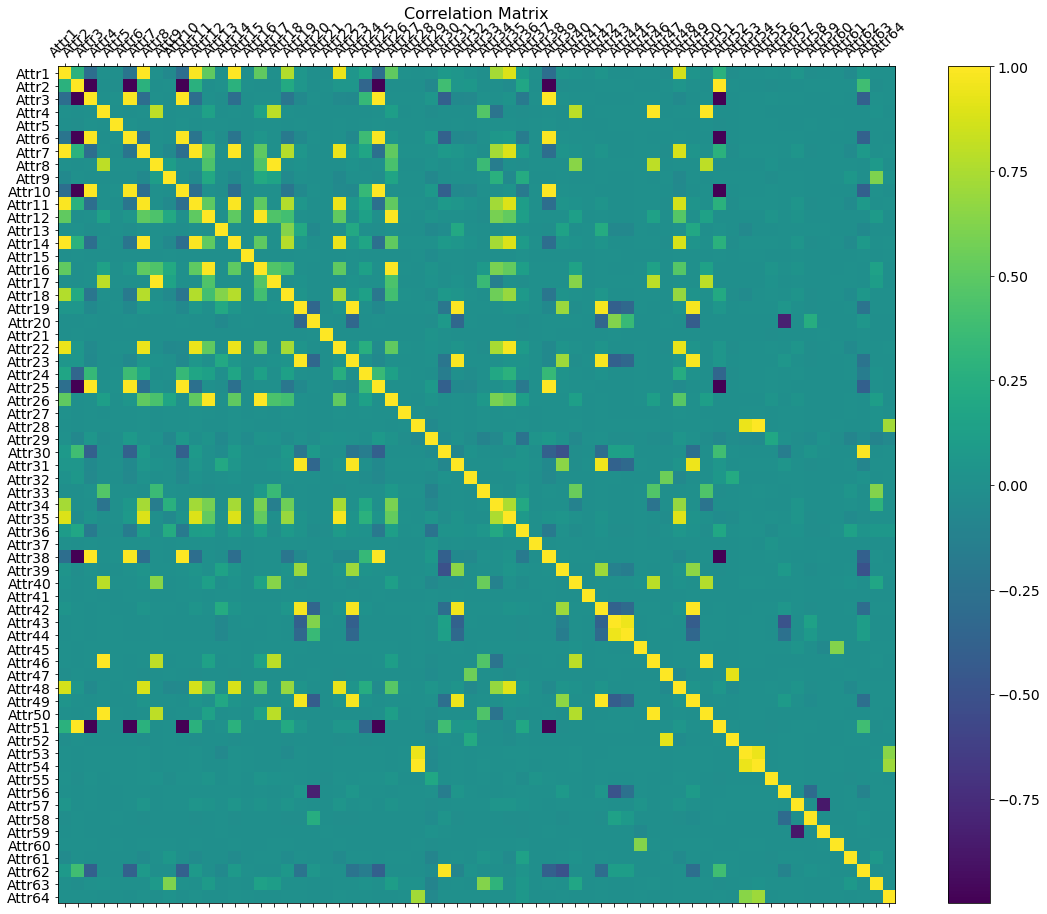

In [36]:
#Preprocessing: Correlation analysis implemented?
show_correlations_large(thirdyearfeat_train)

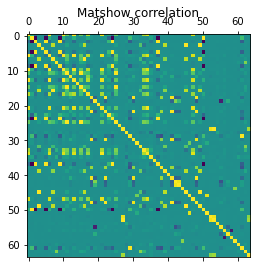

In [37]:
#thirdyearfeat_train.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
show_correlations(thirdyearfeat_train)

[0.01095678 0.01045216 0.01277185 0.01319859 0.01472951 0.01559362
 0.01011524 0.01024648 0.02132175 0.01056021 0.00970053 0.01168544
 0.01490265 0.00817106 0.01588132 0.01600039 0.01122139 0.0096555
 0.00964355 0.01449748 0.03048896 0.01619403 0.0105847  0.02368408
 0.01347898 0.01570741 0.07439855 0.01293007 0.02092253 0.01203171
 0.01115825 0.01161863 0.0128249  0.04284472 0.01512242 0.01377994
 0.01014608 0.0114023  0.0156486  0.01701526 0.01628299 0.01484174
 0.01280697 0.01544629 0.01089677 0.03405397 0.01272836 0.01230653
 0.0110069  0.01130728 0.01102085 0.0111116  0.01207758 0.01431286
 0.02032008 0.02304647 0.01351799 0.02760359 0.00940642 0.01516498
 0.01591749 0.01032355 0.00980928 0.01140183]
1.0


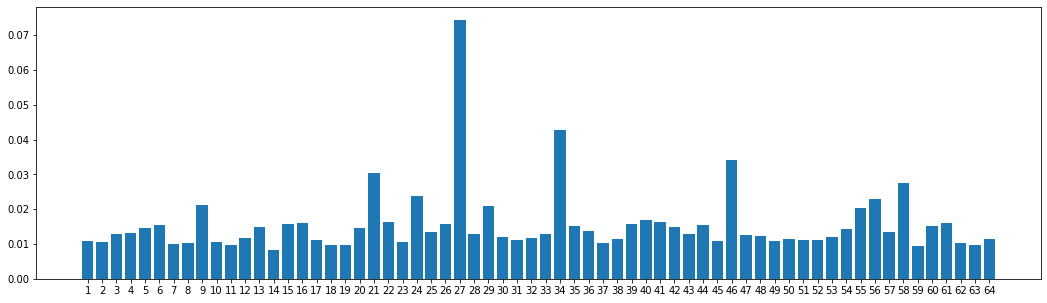

[0.00280074 0.00327351 0.00750691 0.00166191 0.04494564 0.01060533
 0.00198129 0.00881063 0.00636041 0.00124643 0.00883208 0.
 0.         0.01686971 0.01506567 0.0036562  0.         0.00872956
 0.00653545 0.00797468 0.03205572 0.00851247 0.00334938 0.01920589
 0.01051378 0.02231512 0.06340938 0.00373929 0.01126659 0.00990735
 0.00451805 0.01003476 0.00364103 0.17166559 0.0170329  0.01812029
 0.0027963  0.00536235 0.02031161 0.00980322 0.02240667 0.00776614
 0.01048308 0.03366347 0.00841924 0.05730009 0.         0.00311786
 0.01437901 0.02663799 0.01935716 0.00638161 0.0032378  0.00460758
 0.02411261 0.08347335 0.0127735  0.01342691 0.00116891 0.00155061
 0.02877382 0.00670974 0.00240383 0.00343182]
1.0000000000000002


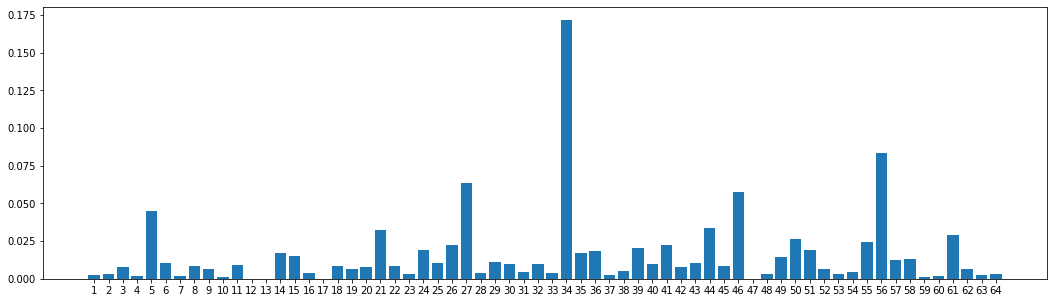

FIRST
[0.01258919 0.00894088 0.01150269 0.01205002 0.01278344 0.02048107
 0.00919742 0.0110111  0.03083216 0.00917808 0.04014405 0.01159193
 0.0130701  0.0095986  0.01356662 0.01260309 0.01093672 0.01143467
 0.01181906 0.01095132 0.01461669 0.01646286 0.01137262 0.01974228
 0.01295616 0.01084969 0.1158962  0.00963842 0.02357211 0.01110569
 0.01224966 0.01023032 0.00980731 0.04705536 0.01472152 0.01166431
 0.00838091 0.01069991 0.01210981 0.01707053 0.01334005 0.0139174
 0.01079634 0.01407437 0.01238747 0.03132542 0.01137245 0.01300008
 0.00974007 0.01009395 0.01076597 0.01093413 0.01207521 0.0146984
 0.01219021 0.0230508  0.01060009 0.01979719 0.00795571 0.01011267
 0.01314984 0.00853786 0.01052693 0.01107283]
1.0


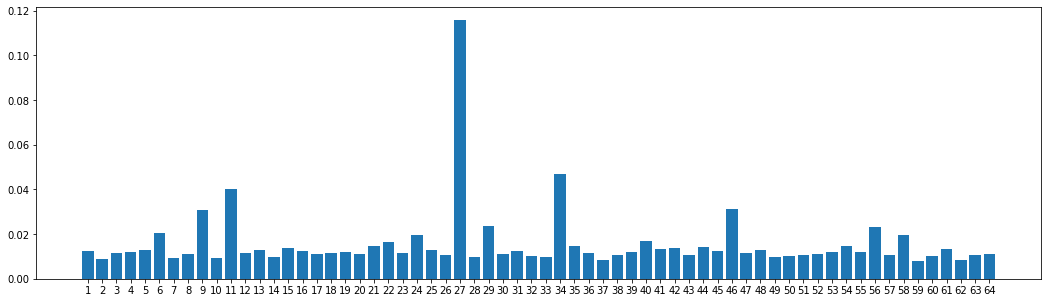

SECOND
[0.01049931 0.00942127 0.01443959 0.0124126  0.0146464  0.02557619
 0.00882377 0.01176896 0.0226978  0.01170404 0.0096809  0.01124436
 0.01115126 0.01031523 0.01401012 0.0137901  0.01066952 0.01001306
 0.01009921 0.01351788 0.0137388  0.01340145 0.01200675 0.021003
 0.0142421  0.0116597  0.07971098 0.01442381 0.02763012 0.01256361
 0.01057661 0.01443486 0.0123497  0.0448329  0.01338969 0.01480015
 0.0095511  0.01363151 0.01090957 0.01895125 0.01780367 0.01445899
 0.01076591 0.01793699 0.01108877 0.03295083 0.01446799 0.01262235
 0.01090547 0.01059293 0.01223068 0.01148041 0.01383666 0.01424225
 0.02070585 0.02046443 0.01262607 0.02738122 0.01027515 0.01326264
 0.01643971 0.01140902 0.01055497 0.01120778]
1.0


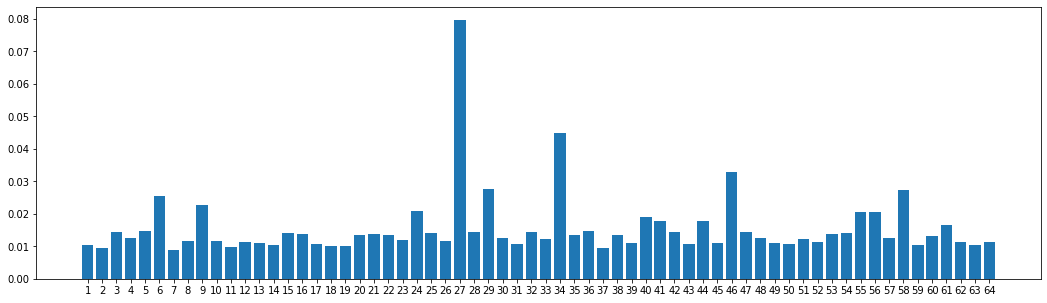

FOURTH
[0.01281374 0.01056765 0.01276249 0.01334578 0.01407582 0.02061077
 0.01042492 0.00880583 0.02015518 0.00998244 0.01360014 0.01171127
 0.01607013 0.01097678 0.01401199 0.01526652 0.01045078 0.01220546
 0.01034249 0.01257915 0.02174178 0.01465832 0.01174087 0.02913278
 0.01462524 0.01632611 0.0642611  0.01355156 0.02118597 0.01049246
 0.01163116 0.01274953 0.01304925 0.03383366 0.02434084 0.01367562
 0.00637594 0.01289285 0.0168913  0.0189175  0.01899573 0.01341718
 0.01157498 0.01787301 0.01182479 0.03475978 0.01388093 0.01586618
 0.01194055 0.01125289 0.01101066 0.01152397 0.01091808 0.013195
 0.01564902 0.02308235 0.01215256 0.02650405 0.0081186  0.01350052
 0.01665738 0.01092656 0.01217257 0.01036949]
1.0


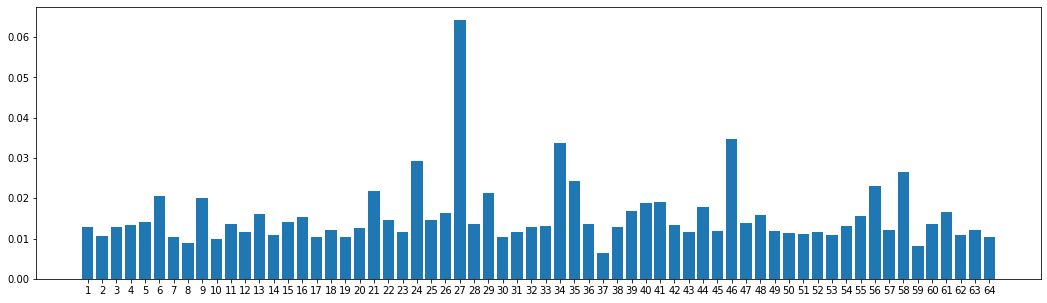

FIFTH
[0.01361359 0.00855284 0.01447987 0.01487683 0.00997989 0.01344765
 0.01030798 0.00977438 0.01077307 0.00849625 0.0155435  0.01002498
 0.02158322 0.01026813 0.01483903 0.01416547 0.00739816 0.0097587
 0.00999167 0.01073545 0.06760041 0.02765498 0.01376487 0.02822787
 0.01318725 0.01425591 0.04934713 0.01223262 0.0169991  0.0089583
 0.01050512 0.01019152 0.00839538 0.02545557 0.0414382  0.01029379
 0.00678207 0.01099516 0.03289579 0.01777117 0.0288006  0.02421811
 0.0115275  0.01299098 0.01219827 0.03118626 0.0094984  0.01071761
 0.0100128  0.01036397 0.00926602 0.00900324 0.01086403 0.01283229
 0.0155809  0.02205096 0.0098481  0.02023724 0.0073752  0.01170174
 0.01256783 0.01002812 0.01160052 0.00996643]
1.0


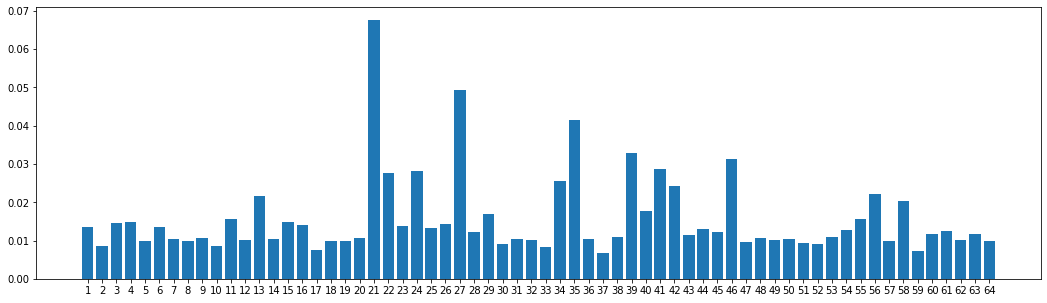

In [38]:
#thirdyear random forest and decision tree
rf_thirdyear = create_dc_rf(thirdyearfeat_train, thirdyearclass_train)
dc_thirdyear = create_dc_rf(thirdyearfeat_train, thirdyearclass_train, 'dc')

importance = rf_thirdyear.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(18,5))
plt.bar([x[4:6] for x, y in thirdyearfeat_train.iteritems()], importance, width=0.8)
plt.show()

importance = dc_thirdyear.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(18,5))
plt.bar([x[4:6] for x, y in thirdyearfeat_train.iteritems()], importance, width=0.8)
plt.show()

rf_firstyear = create_dc_rf(firstyearfeat_train, firstyearclass_train)
rf_secondyear = create_dc_rf(secondyearfeat_train, secondyearclass_train)
rf_fourthyear = create_dc_rf(fourthyearfeat_train, fourthyearclass_train)
rf_fifthyear = create_dc_rf(fifthyearfeat_train, fifthyearclass_train)

print("FIRST")
importance = rf_firstyear.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(18,5))
plt.bar([x[4:6] for x, y in firstyearfeat_train.iteritems()], importance, width=0.8)
plt.show()

print("SECOND")
importance = rf_secondyear.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(18,5))
plt.bar([x[4:6] for x, y in secondyearfeat_train.iteritems()], importance, width=0.8)
plt.show()

print("FOURTH")
importance = rf_fourthyear.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(18,5))
plt.bar([x[4:6] for x, y in fourthyearfeat_train.iteritems()], importance, width=0.8)
plt.show()

print("FIFTH")
importance = rf_fifthyear.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(18,5))
plt.bar([x[4:6] for x, y in fifthyearfeat_train.iteritems()], importance, width=0.8)
plt.show()

In [39]:
## 2a using the base model and datasets to simply remove unimportant features, ignoring any correlations
## 2a feature selection with  -> play around with threshold -> then use thirdyearfeat_train_unimp, thirdyearfeat_test_unimp 
thirdyearfeat_train_imp_01, thirdyearfeat_test_imp_01 = remove_unimportant_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.01)
thirdyearfeat_train_imp_015, thirdyearfeat_test_imp_015 = remove_unimportant_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.015)
thirdyearfeat_train_imp_02, thirdyearfeat_test_imp_02 = remove_unimportant_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.02)
thirdyearfeat_train_imp_03, thirdyearfeat_test_imp_03 = remove_unimportant_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.03)

## 2a feature selection with  -> play around with threshold -> then use thirdyearfeat_train_unimp, thirdyearfeat_test_unimp
thirdyearfeat_train_imp_dc_01, thirdyearfeat_test_imp_dc_01 = remove_unimportant_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.01)
thirdyearfeat_train_imp_dc_015, thirdyearfeat_test_imp_dc_015 = remove_unimportant_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.015)
thirdyearfeat_train_imp_dc_02, thirdyearfeat_test_imp_dc_02 = remove_unimportant_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.02)
thirdyearfeat_train_imp_dc_03, thirdyearfeat_test_imp_dc_03 = remove_unimportant_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, threshold=0.03)


In [40]:
## 2c simply just remove the features that are correlated to the important ones -> Random Forest
thirdyearfeat_train_only_impcorr_5, thirdyearfeat_test_only_impcorr_5 = remove_correlations_important_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, num_features = 5, threshold = 0.5)
thirdyearfeat_train_only_impcorr_10, thirdyearfeat_test_only_impcorr_10 = remove_correlations_important_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, num_features = 10, threshold = 0.5)
thirdyearfeat_train_only_impcorr_15, thirdyearfeat_test_only_impcorr_15 = remove_correlations_important_features(rf_thirdyear, thirdyearfeat_train, thirdyearfeat_test, num_features = 15, threshold = 0.5)

## 2c simply just remove the features that are correlated to the important ones -> Random Forest
thirdyearfeat_train_only_impcorr_dc_5, thirdyearfeat_test_only_impcorr_dc_5 = remove_correlations_important_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, num_features = 5, threshold = 0.5)
thirdyearfeat_train_only_impcorr_dc_10, thirdyearfeat_test_only_impcorr_dc_10 = remove_correlations_important_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, num_features = 10, threshold = 0.5)
thirdyearfeat_train_only_impcorr_dc_15, thirdyearfeat_test_only_impcorr_dc_15 = remove_correlations_important_features(dc_thirdyear, thirdyearfeat_train, thirdyearfeat_test, num_features = 15, threshold = 0.5)

The 5 most important features are: [57 45 20 33 26]
remove  {'Attr48', 'Attr22', 'Attr40', 'Attr18', 'Attr7', 'Attr26', 'Attr11', 'Attr1', 'Attr12', 'Attr4', 'Attr16', 'Attr35', 'Attr8', 'Attr17', 'Attr14', 'Attr50'}
important  {'Attr34', 'Attr46', 'Attr27', 'Attr21', 'Attr58'}
The 10 most important features are: [54 28  8 23 55 57 45 20 33 26]
remove  {'Attr48', 'Attr22', 'Attr40', 'Attr18', 'Attr7', 'Attr26', 'Attr11', 'Attr1', 'Attr12', 'Attr4', 'Attr63', 'Attr16', 'Attr35', 'Attr8', 'Attr17', 'Attr14', 'Attr20', 'Attr50'}
important  {'Attr24', 'Attr56', 'Attr34', 'Attr46', 'Attr9', 'Attr29', 'Attr27', 'Attr21', 'Attr55', 'Attr58'}
The 15 most important features are: [60 15 21 40 20 54 55  8 57 26 28 45 23 33 39]
remove  {'Attr48', 'Attr22', 'Attr11', 'Attr1', 'Attr50', 'Attr40', 'Attr63', 'Attr8', 'Attr17', 'Attr33', 'Attr18', 'Attr26', 'Attr4', 'Attr35', 'Attr20', 'Attr7', 'Attr12', 'Attr34', 'Attr14'}
important  {'Attr22', 'Attr24', 'Attr40', 'Attr56', 'Attr34', 'Attr46', 'Attr61

# ML Approaches

### Naive Bayes

In [41]:
# Tuning Balacing
estimator = GaussianNB()

# w/o balancing
pipeline1 = Pipeline([("classification", estimator)])
pipeline1.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear = pipeline1.predict(thirdyearfeat_test)

# w/ smote oversampling
pipeline2 = Pipeline([("balancing", balancer_smote),("classification", estimator)])
pipeline2.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear_smote = pipeline2.predict(thirdyearfeat_test)

# w/ Randomoversampler
pipeline3 = Pipeline([("balancing", balancer_over),("classification", estimator)])
pipeline3.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear_over = pipeline3.predict(thirdyearfeat_test)

# w/ Randomundersampler
pipeline4 = Pipeline([("balancing", balancer_under),("classification", estimator)])
pipeline4.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear_under = pipeline4.predict(thirdyearfeat_test)
#print(thirdyearclass_test)

print(f"F2 score w/o balancing: {fbeta_score(thirdyearclass_test, bankrupt_predict_thirdyear, average=None, beta=2)[1]}")
print(f"F2 score w/ smote oversampling: {fbeta_score(thirdyearclass_test, bankrupt_predict_thirdyear_smote, average=None, beta=2)[1]}")
print(f"F2 score w/ oversampling: {fbeta_score(thirdyearclass_test, bankrupt_predict_thirdyear_over, average=None, beta=2)[1]}")
print(f"F2 score w/ undersampling: {fbeta_score(thirdyearclass_test, bankrupt_predict_thirdyear_under, average=None, beta=2)[1]}")

F2 score w/o balancing: 0.19607843137254904
F2 score w/ smote oversampling: 0.1930721181147076
F2 score w/ oversampling: 0.19585898153329606
F2 score w/ undersampling: 0.15116279069767444


In [42]:
# Tuning Feature Selection

estimator = GaussianNB()
pipeline = Pipeline([("balancing", balancer_smote),("classification", estimator)])

# w/o feature selection
pipeline.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear = pipeline.predict(thirdyearfeat_test)

# features selection using the decision tree algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_01 = pipeline.predict(thirdyearfeat_test_imp_dc_01)

# features selection using the decision tree algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_dc_015, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_015 = pipeline.predict(thirdyearfeat_test_imp_dc_015)

# features selection using the decision tree algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_dc_02, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_02 = pipeline.predict(thirdyearfeat_test_imp_dc_02)

# features selection using the decision tree algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_dc_03, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_03 = pipeline.predict(thirdyearfeat_test_imp_dc_03)

# features selection using the random forest algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_01, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_01 = pipeline.predict(thirdyearfeat_test_imp_01)

# features selection using the random forest algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_015, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_015 = pipeline.predict(thirdyearfeat_test_imp_015)

# features selection using the random forest algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_02, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_02 = pipeline.predict(thirdyearfeat_test_imp_02)

# features selection using the random forest algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_03, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_03 = pipeline.predict(thirdyearfeat_test_imp_03)

# Removing correlated features to top 5 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_5, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_5)

# Removing correlated features to top 10 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_10, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_10)

# Removing correlated features to top 15 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_15, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_15)

# Removing correlated features to top 5 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_5, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_5)

# Removing correlated features to top 10 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_10, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_10)

# Removing correlated features to top 15 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_15, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_15)


print(f"F2 score w/o feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear)}")
print(f"F2 score w/ dc feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ dc feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_015)}")
print(f"F2 score w/ dc feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ dc feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ rf feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_01)}")
print(f"F2 score w/ rf feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_015)}")
print(f"F2 score w/ rf feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_02)}")
print(f"F2 score w/ rf feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_03)}")
print(f"F2 score w/ removing correlation from top 5 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ removing correlation from top 10 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ removing correlation from top 15 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ removing correlation from top 5 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr5)}")
print(f"F2 score w/ removing correlation from top 10 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr10)}")
print(f"F2 score w/ removing correlation from top 15 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr15)}")

F2 score w/o feature selection: 0.1930721181147076
F2 score w/ dc feature selection (thrs: 0.01): 0.20414031052328924
F2 score w/ dc feature selection (thrs: 0.015): 0.20543981481481483
F2 score w/ dc feature selection (thrs: 0.02): 0.2050837666088966
F2 score w/ dc feature selection (thrs: 0.03): 0.19755147468002224
F2 score w/ rf feature selection (thrs: 0.01): 0.19340159271899884
F2 score w/ rf feature selection (thrs: 0.015): 0.2029731275014294
F2 score w/ rf feature selection (thrs: 0.02): 0.19900497512437812
F2 score w/ rf feature selection (thrs: 0.03): 0.1957585644371941
F2 score w/ removing correlation from top 5 dc feature selection: 0.20414031052328924
F2 score w/ removing correlation from top 10 dc feature selection: 0.2050837666088966
F2 score w/ removing correlation from top 15 dc feature selection: 0.19755147468002224
F2 score w/ removing correlation from top 5 rf feature selection: 0.19241652518392754
F2 score w/ removing correlation from top 10 rf feature selection: 0.

In [43]:
#print(thirdyearfeat_test_imp_dc_01.head())
print(len(thirdyearfeat_test_imp_dc_01.transpose()))

#print(thirdyearfeat_test_only_impcorr_dc_5.head())
print(len(thirdyearfeat_test_only_impcorr_dc_5.transpose()))

27
47


In [44]:
# Experimenting w/ binning
estimator = GaussianNB()

# w/o binning
pipeline1 = Pipeline([("balancing", balancer_smote),("classification", estimator)])
pipeline1.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_01 = pipeline1.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 5 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=5) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_5bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 10 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=10) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_10bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 15 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=15) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_15bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 20 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=20) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_20bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 30 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=30) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_30bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 50 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=50) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_50bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)

# w/ discretization in 100 bins
pipeline2 = Pipeline([("discretizing", discretizer),("balancing", balancer_smote), ("classification", estimator)])
pipeline2.set_params(discretizing__n_bins=100) 
pipeline2.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_100bin = pipeline2.predict(thirdyearfeat_test_imp_dc_01)


print(f"F2 score w/o binning: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ discretization in 5 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_5bin)}")
print(f"F2 score w/ discretization in 10 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_10bin)}")
print(f"F2 score w/ discretization in 15 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_15bin)}")
print(f"F2 score w/ discretization in 20 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_20bin)}")
print(f"F2 score w/ discretization in 30 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_30bin)}")
print(f"F2 score w/ discretization in 0 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_50bin)}")
print(f"F2 score w/ discretization in 100 bins: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_100bin)}")

F2 score w/o binning: 0.20414031052328924
F2 score w/ discretization in 5 bins: 0.20285087719298248
F2 score w/ discretization in 10 bins: 0.2039691289966924
F2 score w/ discretization in 15 bins: 0.1967654986522911
F2 score w/ discretization in 20 bins: 0.20075963103635375
F2 score w/ discretization in 30 bins: 0.1990185387131952
F2 score w/ discretization in 0 bins: 0.1995626025150355
F2 score w/ discretization in 100 bins: 0.2015461071231364


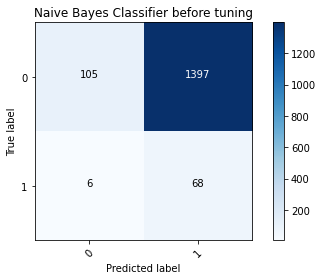

              precision    recall  f1-score   support

           0       0.95      0.07      0.13      1502
           1       0.05      0.92      0.09        74

    accuracy                           0.11      1576
   macro avg       0.50      0.49      0.11      1576
weighted avg       0.90      0.11      0.13      1576



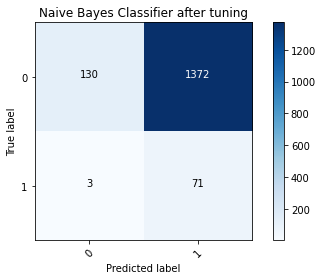

              precision    recall  f1-score   support

           0       0.98      0.09      0.16      1502
           1       0.05      0.96      0.09        74

    accuracy                           0.13      1576
   macro avg       0.51      0.52      0.13      1576
weighted avg       0.93      0.13      0.16      1576



In [45]:
# Confusion Matrix

labels = [0,1]
#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, bankrupt_predict_thirdyear)
#print(cnf_matrix)
cnf_matrix2 = confusion_matrix(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='Naive Bayes Classifier before tuning')
print(sklearn.metrics.classification_report(thirdyearclass_test, bankrupt_predict_thirdyear))
plot_confusion_matrix(cnf_matrix2, classes = labels, title='Naive Bayes Classifier after tuning')
print(sklearn.metrics.classification_report(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01))

### XGBoost

In [46]:
#1) data with and without balancing -> underbalancing is the best
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.1,
                    max_depth = 3, alpha = 10)
##balancing_over ++
pipeline = Pipeline([("balancing", balancer_over), ("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))

##balancing_under
pipeline = Pipeline([("balancing", balancer_under), ("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))

##no balancing
pipeline = Pipeline([("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))

##smote balancer
pipeline = Pipeline([("balancing", balancer_smote), ("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))
print(fbeta_score(thirdyearclass_test, xg_preds, average=None, beta=2)[1])
print(fbeta_score(thirdyearclass_test, xg_preds, average=None, beta=2, pos_label=1))

0.5313351498637603
0.41920731707317077
0.47761194029850745
0.4935064935064935
0.4935064935064935
[0.96797865 0.49350649]


In [47]:
# Tuning Feature Selection
#xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.2,
         #           max_depth = 3, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.5, learning_rate = 0.4,
                    max_depth = 3, alpha = 2)

pipeline = Pipeline([("balancing", balancer_over),("classification", xg_reg)])

# w/o feature selection
pipeline.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear = pipeline.predict(thirdyearfeat_test)

# features selection using the decision tree algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_01 = pipeline.predict(thirdyearfeat_test_imp_dc_01)

# features selection using the decision tree algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_dc_015, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_015 = pipeline.predict(thirdyearfeat_test_imp_dc_015)

# features selection using the decision tree algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_dc_02, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_02 = pipeline.predict(thirdyearfeat_test_imp_dc_02)
print(len(thirdyearfeat_test_imp_dc_02.transpose()))

# features selection using the decision tree algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_dc_03, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_03 = pipeline.predict(thirdyearfeat_test_imp_dc_03)

# features selection using the random forest algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_01, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_01 = pipeline.predict(thirdyearfeat_test_imp_01)

# features selection using the random forest algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_015, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_015 = pipeline.predict(thirdyearfeat_test_imp_015)

# features selection using the random forest algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_02, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_02 = pipeline.predict(thirdyearfeat_test_imp_02)

# features selection using the random forest algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_03, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_03 = pipeline.predict(thirdyearfeat_test_imp_03)

# Removing correlated features to top 5 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_5, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_5)

# Removing correlated features to top 10 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_10, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_10)
print(len(thirdyearfeat_test_only_impcorr_dc_10.transpose()))

# Removing correlated features to top 15 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_15, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_15)

# Removing correlated features to top 5 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_5, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_5)

# Removing correlated features to top 10 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_10, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_10)

# Removing correlated features to top 15 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_15, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_15)


print(f"F2 score w/o feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear)}")
print(f"F2 score w/ dc feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ dc feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_015)}")
print(f"F2 score w/ dc feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ dc feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ rf feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_01)}")
print(f"F2 score w/ rf feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_015)}")
print(f"F2 score w/ rf feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_02)}")
print(f"F2 score w/ rf feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_03)}")
print(f"F2 score w/ removing correlation from top 5 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ removing correlation from top 10 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ removing correlation from top 15 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ removing correlation from top 5 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr5)}")
print(f"F2 score w/ removing correlation from top 10 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr10)}")
print(f"F2 score w/ removing correlation from top 15 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr15)}")

13
46
F2 score w/o feature selection: 0.582010582010582
F2 score w/ dc feature selection (thrs: 0.01): 0.5470737913486006
F2 score w/ dc feature selection (thrs: 0.015): 0.52757793764988
F2 score w/ dc feature selection (thrs: 0.02): 0.5501222493887531
F2 score w/ dc feature selection (thrs: 0.03): 0.5172413793103449
F2 score w/ rf feature selection (thrs: 0.01): 0.5347593582887701
F2 score w/ rf feature selection (thrs: 0.015): 0.5357142857142857
F2 score w/ rf feature selection (thrs: 0.02): 0.4789719626168224
F2 score w/ rf feature selection (thrs: 0.03): 0.4446640316205534
F2 score w/ removing correlation from top 5 dc feature selection: 0.5470737913486006
F2 score w/ removing correlation from top 10 dc feature selection: 0.5501222493887531
F2 score w/ removing correlation from top 15 dc feature selection: 0.5172413793103449
F2 score w/ removing correlation from top 5 rf feature selection: 0.5687830687830687
F2 score w/ removing correlation from top 10 rf feature selection: 0.57486

C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 36 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 58 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


0.352760736196319


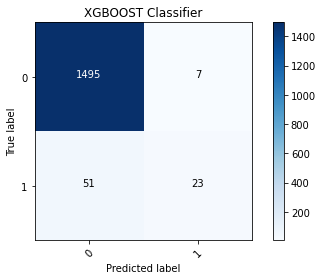

In [48]:
#3) with and without discretization (try out different bin sizes) => Without binning is better
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.1,
                    max_depth = 3, alpha = 10)
"""
encode:
    ordinal - returns bin identifiers as integers
strategy: 
    uniform - same width of bins
    quantile - same number of points per bin
    
Evaluation:
    I think binning does not make sense for us, because it bins all features with the same logic
    - > we loose a lot of information
"""

discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

pipeline = Pipeline([("discretizing", discretizer), ("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))

labels = [0,1]
#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, xg_preds)

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')

In [49]:
#4) change the train/test split ratio (90/10; 80/20; 70/30; 60/40?) -> change above in the dataset generation code

bestsplit=0
bestscore=0
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.1,
                    max_depth = 3, alpha = 10)
for i in np.arange(0.05, 0.5, 0.05):
    thirdyearfeat_train_raw, thirdyearfeat_test_raw, thirdyearclass_train2, thirdyearclass_test2 = featuresnclass(thirdyear, i)

    # replace missing values
    thirdyearfeat_train2 = replacemissingtrain(thirdyearfeat_train_raw)
    thirdyearfeat_test2 = replacemissingtest(thirdyearfeat_test_raw, thirdyearfeat_train_raw)

    #normalized the data using min max scaler
    scaler = preprocessing.MinMaxScaler()
    thirdyearfeat_train2 = scaler.fit_transform(thirdyearfeat_train2)
    thirdyearfeat_test2 = scaler.transform(thirdyearfeat_test2)
    
    thirdyearfeat_train2 = pd.DataFrame(thirdyearfeat_train2, columns = thirdyearfeat_train_raw.columns)
    thirdyearfeat_test2 = pd.DataFrame(thirdyearfeat_test2, columns = thirdyearfeat_train_raw.columns)
                                       
    xg_reg.fit(thirdyearfeat_train2,thirdyearclass_train2)
    xg_preds = xg_reg.predict(thirdyearfeat_test2)
    if (getf2(thirdyearclass_test2, xg_preds) > bestscore):
        bestsplit=i
        bestscore=getf2(thirdyearclass_test2, xg_preds)
    print(f"F2 score: {getf2(thirdyearclass_test2, xg_preds)} - With test size:{i}")
print(f"Best result: {bestscore} with split: {bestsplit}")

F2 score: 0.3097345132743363 - With test size:0.05
F2 score: 0.4366812227074236 - With test size:0.1
F2 score: 0.4477611940298508 - With test size:0.15000000000000002
F2 score: 0.45248868778280543 - With test size:0.2
F2 score: 0.3825136612021858 - With test size:0.25
F2 score: 0.3669724770642202 - With test size:0.3
F2 score: 0.3655352480417755 - With test size:0.35000000000000003
F2 score: 0.35428571428571426 - With test size:0.4
F2 score: 0.38539553752535494 - With test size:0.45
Best result: 0.45248868778280543 with split: 0.2


In [50]:
#5) hyperparameter tuning => Best score: 0.4185022026431718 with learning rate: 1.6

best = 0
score = 0
for i in np.arange(0.1, 4, 0.1):
    print(f"Learning rate: {i}")
    xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = i,
                    max_depth = 3, alpha = 10)
    xg_reg.fit(thirdyearfeat_train,thirdyearclass_train)
    xg_preds = xg_reg.predict(thirdyearfeat_test)
    print(f"F2 score: {getf2(thirdyearclass_test, xg_preds)}")
    if score < getf2(thirdyearclass_test, xg_preds):
        best = i
        score = getf2(thirdyearclass_test, xg_preds)
print(f"Best score: {score} with learning rate: {best}")

Learning rate: 0.1
F2 score: 0.253968253968254
Learning rate: 0.2
F2 score: 0.3715170278637771
Learning rate: 0.30000000000000004
F2 score: 0.39755351681957185
Learning rate: 0.4
F2 score: 0.4518072289156627
Learning rate: 0.5
F2 score: 0.41033434650455924
Learning rate: 0.6
F2 score: 0.4354354354354354
Learning rate: 0.7000000000000001
F2 score: 0.4477611940298508
Learning rate: 0.8
F2 score: 0.43806646525679765
Learning rate: 0.9
F2 score: 0.4599406528189911
Learning rate: 1.0
F2 score: 0.42168674698795183
Learning rate: 1.1
F2 score: 0.47761194029850745
Learning rate: 1.2000000000000002
F2 score: 0.47619047619047616
Learning rate: 1.3000000000000003
F2 score: 0.5044510385756676
Learning rate: 1.4000000000000001
F2 score: 0.4810495626822157
Learning rate: 1.5000000000000002
F2 score: 0.45722713864306785
Learning rate: 1.6
F2 score: 0.44117647058823534
Learning rate: 1.7000000000000002
F2 score: 0.44117647058823534
Learning rate: 1.8000000000000003
F2 score: 0.44117647058823534
Learni

C:\Users\Flo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


F2 score: nan
Learning rate: 2.9000000000000004
F2 score: 0.04132231404958678
Learning rate: 3.0000000000000004
F2 score: 0.17520215633423183
Learning rate: 3.1
F2 score: 0.30183727034120733
Learning rate: 3.2


C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F2 score: nan
Learning rate: 3.3000000000000003
F2 score: 0.17808219178082194
Learning rate: 3.4000000000000004
F2 score: 0.3287671232876712
Learning rate: 3.5000000000000004
F2 score: 0.09641873278236913
Learning rate: 3.6
F2 score: 0.18867924528301888
Learning rate: 3.7
F2 score: 0.13513513513513514
Learning rate: 3.8000000000000003
F2 score: 0.15068493150684933
Learning rate: 3.9000000000000004
F2 score: 0.15068493150684933
Best score: 0.5044510385756676 with learning rate: 1.3000000000000003


0.6202531645569621


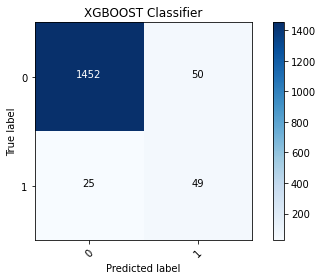

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1502
           1       0.49      0.66      0.57        74

    accuracy                           0.95      1576
   macro avg       0.74      0.81      0.77      1576
weighted avg       0.96      0.95      0.96      1576



In [51]:
## Best Model
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.5, learning_rate = 0.4,
                    max_depth = 3, alpha = 2)
##balancing_over ++
pipeline = Pipeline([("balancing", balancer_over), ("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train_only_impcorr_15,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test_only_impcorr_15)
print(getf2(thirdyearclass_test, xg_preds))

cnf_matrix = confusion_matrix(thirdyearclass_test, xg_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')

print(sklearn.metrics.classification_report(thirdyearclass_test, xg_preds))

FIRST
0.7352941176470588


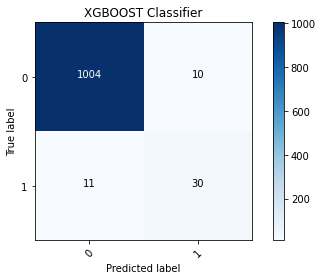

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1014
           1       0.75      0.73      0.74        41

    accuracy                           0.98      1055
   macro avg       0.87      0.86      0.87      1055
weighted avg       0.98      0.98      0.98      1055

SECOND
0.5647840531561462


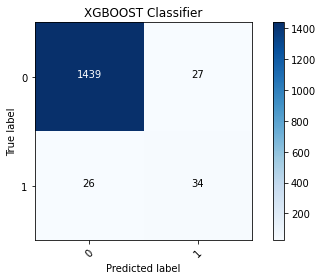

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1466
           1       0.56      0.57      0.56        60

    accuracy                           0.97      1526
   macro avg       0.77      0.77      0.77      1526
weighted avg       0.97      0.97      0.97      1526

THIRD
FOURTH
0.6426735218508998


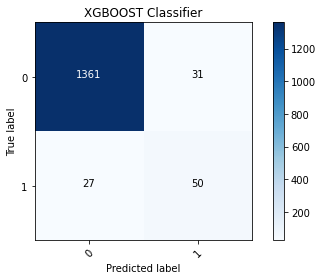

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1392
           1       0.62      0.65      0.63        77

    accuracy                           0.96      1469
   macro avg       0.80      0.81      0.81      1469
weighted avg       0.96      0.96      0.96      1469

FITH
0.7395498392282959


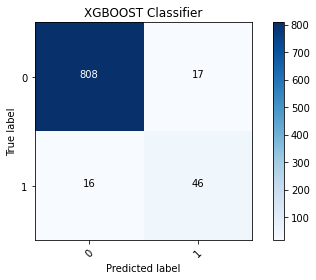

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       825
           1       0.73      0.74      0.74        62

    accuracy                           0.96       887
   macro avg       0.86      0.86      0.86       887
weighted avg       0.96      0.96      0.96       887



In [52]:
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.5, learning_rate = 0.4,
                    max_depth = 3, alpha = 2)
##balancing_over ++
print("FIRST")
pipeline = Pipeline([("balancing", balancer_over), ("classification", xg_reg)])
pipeline.fit(firstyearfeat_train,firstyearclass_train)
xg_preds = pipeline.predict(firstyearfeat_test)
print(getf2(firstyearclass_test, xg_preds))
cnf_matrix = confusion_matrix(firstyearclass_test, xg_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')
print(sklearn.metrics.classification_report(firstyearclass_test, xg_preds))

print("SECOND")
pipeline = Pipeline([("balancing", balancer_over), ("classification", xg_reg)])
pipeline.fit(secondyearfeat_train, secondyearclass_train)
xg_preds = pipeline.predict(secondyearfeat_test)
print(getf2(secondyearclass_test, xg_preds))
cnf_matrix = confusion_matrix(secondyearclass_test, xg_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')
print(sklearn.metrics.classification_report(secondyearclass_test, xg_preds))

print("THIRD")

print("FOURTH")
pipeline = Pipeline([("balancing", balancer_over), ("classification", xg_reg)])
pipeline.fit(fourthyearfeat_train, fourthyearclass_train)
xg_preds = pipeline.predict(fourthyearfeat_test)
print(getf2(fourthyearclass_test, xg_preds))
cnf_matrix = confusion_matrix(fourthyearclass_test, xg_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')
print(sklearn.metrics.classification_report(fourthyearclass_test, xg_preds))

print("FITH")
pipeline = Pipeline([("balancing", balancer_over), ("classification", xg_reg)])
pipeline.fit(fifthyearfeat_train, fifthyearclass_train)
xg_preds = pipeline.predict(fifthyearfeat_test)
print(getf2(fifthyearclass_test, xg_preds))
cnf_matrix = confusion_matrix(fifthyearclass_test, xg_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')
print(sklearn.metrics.classification_report(fifthyearclass_test, xg_preds))

0.3787878787878788


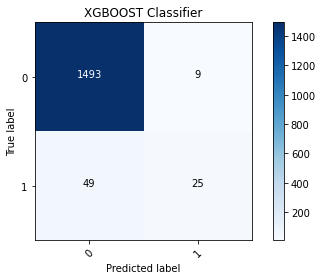

In [53]:
## Raw data test, for baseline

xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.0, max_depth = 3, alpha = 10, n_estimators = 10)
pipeline = Pipeline([("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))

labels = [0,1]
#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, xg_preds)
#print(cnf_matrix)

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')

0.3557312252964427


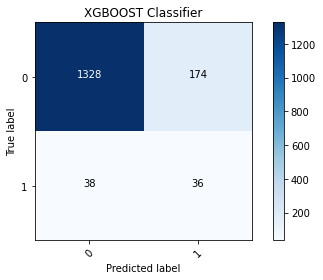

0.2978056426332289


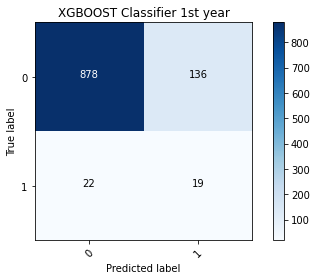

0.16796640671865623


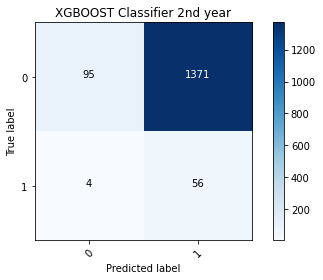

0.3317535545023696


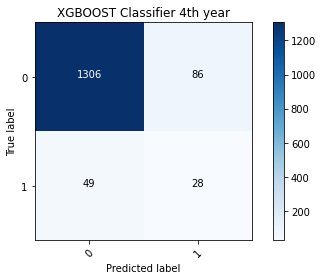

0.22184300341296928


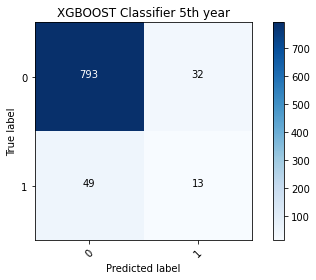

In [54]:
## Print the best combination - predictions for all years using model trained on year 3
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.9, max_depth = 3, alpha = 10, n_estimators = 10)
pipeline = Pipeline([("balancing", balancer_smote), ("classification", xg_reg)])
pipeline.fit(thirdyearfeat_train, thirdyearclass_train)
xg_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, xg_preds))
cnf_matrix = confusion_matrix(thirdyearclass_test, xg_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier')


## Best parameters tried for other years
# First
xg_preds1 = pipeline.predict(firstyearfeat_test)
print(getf2(firstyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(firstyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 1st year')

# Second
xg_preds1 = pipeline.predict(secondyearfeat_test)
print(getf2(secondyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(secondyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 2nd year')

# Fourth
xg_preds1 = pipeline.predict(fourthyearfeat_test)
print(getf2(fourthyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(fourthyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 4th year')

# Fifth
xg_preds1 = pipeline.predict(fifthyearfeat_test)
print(getf2(fifthyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(fifthyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 5th year')

0.5622489959839357


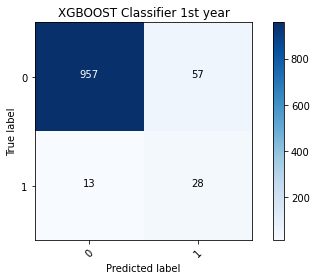

0.4205607476635514


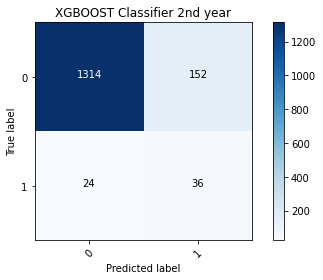

0.326797385620915


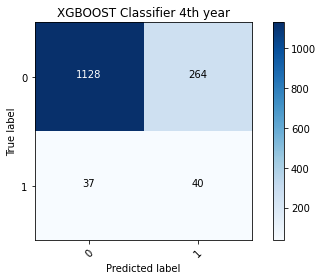

0.49278846153846145


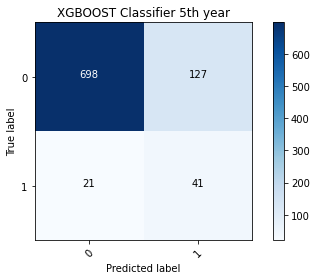

In [55]:
## Best parameters retrained and printed for other years
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.9, max_depth = 3, alpha = 10, n_estimators = 10)
pipeline = Pipeline([("balancing", balancer_smote), ("classification", xg_reg)])

# First
pipeline.fit(firstyearfeat_train,firstyearclass_train)
xg_preds1 = pipeline.predict(firstyearfeat_test)
print(getf2(firstyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(firstyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 1st year')

# Second
pipeline.fit(secondyearfeat_train,secondyearclass_train)
xg_preds1 = pipeline.predict(secondyearfeat_test)
print(getf2(secondyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(secondyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 2nd year')

# Fourth
pipeline.fit(fourthyearfeat_train,fourthyearclass_train)
xg_preds1 = pipeline.predict(fourthyearfeat_test)
print(getf2(fourthyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(fourthyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 4th year')

# Fifth
pipeline.fit(fifthyearfeat_train,fifthyearclass_train)
xg_preds1 = pipeline.predict(fifthyearfeat_test)
print(getf2(fifthyearclass_test, xg_preds1))
cnf_matrix = confusion_matrix(fifthyearclass_test, xg_preds1)
plot_confusion_matrix(cnf_matrix, classes = labels, title='XGBOOST Classifier 5th year')

# Random Forest

In [56]:
#1) data with and without balancing 
rf_reg = RandomForestClassifier()
##balancing_over
pipeline = Pipeline([("balancing", balancer_over), ("classification", rf_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_over=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score with balancing over is: {f2_score_over} ")


##balancing_under
pipeline = Pipeline([("balancing", balancer_under), ("classification", rf_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_under=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score with balancing under is: {f2_score_under} ")

##no balancing
pipeline = Pipeline([("classification", rf_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_no=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score without balancing : {f2_score_no} ")


##smote balancer
pipeline = Pipeline([("balancing", balancer_smote), ("classification", rf_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_smote=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score using smote is: {f2_score_smote} ")

The f2 score with balancing over is: 0.22292993630573252 
The f2 score with balancing under is: 0.4222222222222223 
The f2 score without balancing : 0.1916932907348243 
The f2 score using smote is: 0.4310344827586207 


In [57]:
# Tuning Feature Selection
#xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 1.2,
         #           max_depth = 3, alpha = 10, n_estimators = 10)

rf_reg = RandomForestClassifier(criterion='gini', n_estimators=70)

pipeline = Pipeline([("balancing", balancer_smote),("classification", rf_reg)])

# w/o feature selection
pipeline.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear = pipeline.predict(thirdyearfeat_test)

# features selection using the decision tree algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_01 = pipeline.predict(thirdyearfeat_test_imp_dc_01)

# features selection using the decision tree algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_dc_015, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_015 = pipeline.predict(thirdyearfeat_test_imp_dc_015)

# features selection using the decision tree algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_dc_02, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_02 = pipeline.predict(thirdyearfeat_test_imp_dc_02)

# features selection using the decision tree algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_dc_03, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_03 = pipeline.predict(thirdyearfeat_test_imp_dc_03)

# features selection using the random forest algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_01, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_01 = pipeline.predict(thirdyearfeat_test_imp_01)

# features selection using the random forest algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_015, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_015 = pipeline.predict(thirdyearfeat_test_imp_015)

# features selection using the random forest algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_02, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_02 = pipeline.predict(thirdyearfeat_test_imp_02)

# features selection using the random forest algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_03, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_03 = pipeline.predict(thirdyearfeat_test_imp_03)

# Removing correlated features to top 5 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_5, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_5)

# Removing correlated features to top 10 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_10, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_10)

# Removing correlated features to top 15 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_15, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_15)

# Removing correlated features to top 5 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_5, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_5)

# Removing correlated features to top 10 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_10, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_10)

# Removing correlated features to top 15 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_15, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_15)

print(f"F2 score w/o feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear)}")
print(f"F2 score w/ dc feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ dc feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_015)}")
print(f"F2 score w/ dc feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ dc feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ rf feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_01)}")
print(f"F2 score w/ rf feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_015)}")
print(f"F2 score w/ rf feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_02)}")
print(f"F2 score w/ rf feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_03)}")
print(f"F2 score w/ removing correlation from top 5 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ removing correlation from top 10 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ removing correlation from top 15 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ removing correlation from top 5 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr5)}")
print(f"F2 score w/ removing correlation from top 10 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr10)}")
print(f"F2 score w/ removing correlation from top 15 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr15)}")

F2 score w/o feature selection: 0.41193181818181823
F2 score w/ dc feature selection (thrs: 0.01): 0.41666666666666674
F2 score w/ dc feature selection (thrs: 0.015): 0.43243243243243246
F2 score w/ dc feature selection (thrs: 0.02): 0.4691689008042895
F2 score w/ dc feature selection (thrs: 0.03): 0.5025773195876289
F2 score w/ rf feature selection (thrs: 0.01): 0.38904899135446686
F2 score w/ rf feature selection (thrs: 0.015): 0.48
F2 score w/ rf feature selection (thrs: 0.02): 0.33333333333333337
F2 score w/ rf feature selection (thrs: 0.03): 0.3663793103448276
F2 score w/ removing correlation from top 5 dc feature selection: 0.41666666666666674
F2 score w/ removing correlation from top 10 dc feature selection: 0.4691689008042895
F2 score w/ removing correlation from top 15 dc feature selection: 0.5025773195876289
F2 score w/ removing correlation from top 5 rf feature selection: 0.3661971830985915
F2 score w/ removing correlation from top 10 rf feature selection: 0.3977272727272727

C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 36 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 58 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


The f2 score is: 0.16181229773462782 


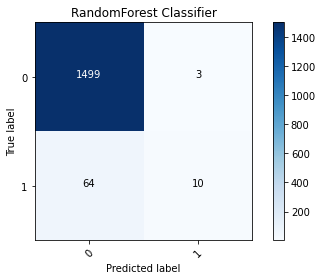

In [58]:
#3) with and without discretization (try out different bin sizes) -> Best result with 8 bins 
rf_reg = RandomForestClassifier()
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

pipeline = Pipeline([("discretizing", discretizer), ("classification", rf_reg)])
model=pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = model.predict(thirdyearfeat_test)
f2_score=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score is: {f2_score} ")


labels = [0,1]
#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, rf_preds)

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='RandomForest Classifier')

In [59]:
#5) hyperparameter tuning 
# Create the parameter grid 
param_grid = {
    'criterion': ["entropy","gini"],
    'min_samples_split': [4,8, 10, 12],
    'n_estimators': [10, 50, 70, 100]
}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2)

grid_search.fit(thirdyearfeat_train,thirdyearclass_train)
print(f"Best paramater is: {grid_search.best_params_} ")

Best paramater is: {'criterion': 'gini', 'min_samples_split': 4, 'n_estimators': 50} 


In [60]:
rf_reg = RandomForestClassifier(**grid_search.best_params_)
rf_reg.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = rf_reg.predict(thirdyearfeat_test)
print(f"F2 score: {getf2(thirdyearclass_test, rf_preds)}")

F2 score: 0.20700636942675157


0.49222797927461137


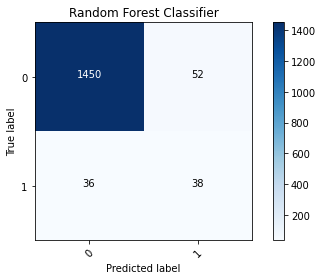

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1502
           1       0.42      0.51      0.46        74

    accuracy                           0.94      1576
   macro avg       0.70      0.74      0.72      1576
weighted avg       0.95      0.94      0.95      1576



In [61]:
## Best Model
rf_reg = RandomForestClassifier(n_estimators=70, criterion='gini')
##balancing_over ++
pipeline = Pipeline([("balancing", balancer_smote), ("classification", rf_reg)])
pipeline.fit(thirdyearfeat_train_imp_dc_03,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test_imp_dc_03)
print(getf2(thirdyearclass_test, rf_preds))

cnf_matrix = confusion_matrix(thirdyearclass_test, rf_preds)
plot_confusion_matrix(cnf_matrix, classes = labels, title='Random Forest Classifier')
print(sklearn.metrics.classification_report(thirdyearclass_test, rf_preds))

0.1916932907348243


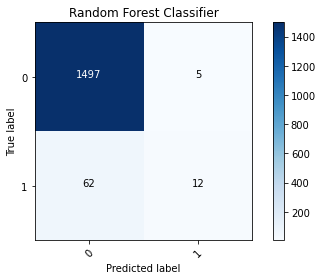

In [62]:
## Raw data test, for baseline

rf_reg = RandomForestClassifier()
pipeline = Pipeline([("classification", rf_reg)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
print(getf2(thirdyearclass_test, rf_preds))

labels = [0,1]
#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, rf_preds)
#print(cnf_matrix)

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='Random Forest Classifier')


## KNN

In [63]:
#1) data with and without balancing 
knn_estimator = KNeighborsClassifier(n_neighbors=10)
##balancing_over
pipeline = Pipeline([("balancing", balancer_over), ("classification", knn_estimator)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_over=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score with balancing over is: {f2_score_over} ")

##balancing_under
pipeline = Pipeline([("balancing", balancer_under), ("classification", knn_estimator)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_under=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score with balancing under is: {f2_score_under} ")

##no balancing
pipeline = Pipeline([("classification", knn_estimator)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_no=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score without balancing : {f2_score_no} ")

##smote balancer
pipeline = Pipeline([("balancing", balancer_smote), ("classification", knn_estimator)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
rf_preds = pipeline.predict(thirdyearfeat_test)
f2_score_smote=(getf2(thirdyearclass_test, rf_preds))
print(f"The f2 score using smote is: {f2_score_smote} ")

The f2 score with balancing over is: 0.20304568527918784 
The f2 score with balancing under is: 0.22845953002610964 


C:\Users\Flo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Flo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


The f2 score without balancing : nan 
The f2 score using smote is: 0.24425287356321843 


[0.99024262 0.        ]


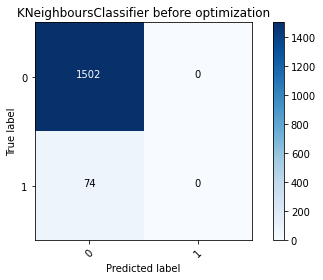

In [64]:
# Base Line for this model
#no balancing
pipeline = Pipeline([("classification", knn_estimator)])
pipeline.fit(thirdyearfeat_train,thirdyearclass_train)
knn_preds = pipeline.predict(thirdyearfeat_test)
print((fbeta_score(thirdyearclass_test,knn_preds,average=None,beta=2)))

labels = [0,1]
#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, knn_preds)
#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='KNeighboursClassifier before optimization')

In [65]:
# Tuning Feature Selection
knn_estimator = KNeighborsClassifier(n_neighbors=10)

pipeline = Pipeline([("balancing", balancer_smote),("classification", knn_estimator)])

# w/o feature selection
pipeline.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear = pipeline.predict(thirdyearfeat_test)

# features selection using the decision tree algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_dc_01, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_01 = pipeline.predict(thirdyearfeat_test_imp_dc_01)

# features selection using the decision tree algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_dc_015, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_015 = pipeline.predict(thirdyearfeat_test_imp_dc_015)

# features selection using the decision tree algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_dc_02, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_02 = pipeline.predict(thirdyearfeat_test_imp_dc_02)

# features selection using the decision tree algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_dc_03, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_03 = pipeline.predict(thirdyearfeat_test_imp_dc_03)

# features selection using the random forest algorithm (threshold 0.01)
pipeline.fit(thirdyearfeat_train_imp_01, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_01 = pipeline.predict(thirdyearfeat_test_imp_01)

# features selection using the random forest algorithm (threshold 0.015)
pipeline.fit(thirdyearfeat_train_imp_015, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_015 = pipeline.predict(thirdyearfeat_test_imp_015)

# features selection using the random forest algorithm (threshold 0.02)
pipeline.fit(thirdyearfeat_train_imp_02, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_02 = pipeline.predict(thirdyearfeat_test_imp_02)

# features selection using the random forest algorithm (threshold 0.03)
pipeline.fit(thirdyearfeat_train_imp_03, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_03 = pipeline.predict(thirdyearfeat_test_imp_03)

# Removing correlated features to top 5 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_5, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_5)

# Removing correlated features to top 10 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_10, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_10)

# Removing correlated features to top 15 decision tree important features
pipeline.fit(thirdyearfeat_train_only_impcorr_dc_15, thirdyearclass_train)
bankrupt_predict_thirdyear_dc_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_dc_15)

# Removing correlated features to top 5 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_5, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr5 = pipeline.predict(thirdyearfeat_test_only_impcorr_5)

# Removing correlated features to top 10 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_10, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr10 = pipeline.predict(thirdyearfeat_test_only_impcorr_10)

# Removing correlated features to top 15 random forest important features
pipeline.fit(thirdyearfeat_train_only_impcorr_15, thirdyearclass_train)
bankrupt_predict_thirdyear_rf_impcorr15 = pipeline.predict(thirdyearfeat_test_only_impcorr_15)


print(f"F2 score w/o feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear)}")
print(f"F2 score w/ dc feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ dc feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_015)}")
print(f"F2 score w/ dc feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ dc feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ rf feature selection (thrs: 0.01): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_01)}")
print(f"F2 score w/ rf feature selection (thrs: 0.015): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_015)}")
print(f"F2 score w/ rf feature selection (thrs: 0.02): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_02)}")
print(f"F2 score w/ rf feature selection (thrs: 0.03): {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_03)}")
print(f"F2 score w/ removing correlation from top 5 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_01)}")
print(f"F2 score w/ removing correlation from top 10 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_02)}")
print(f"F2 score w/ removing correlation from top 15 dc feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_dc_03)}")
print(f"F2 score w/ removing correlation from top 5 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr5)}")
print(f"F2 score w/ removing correlation from top 10 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr10)}")
print(f"F2 score w/ removing correlation from top 15 rf feature selection: {getf2(thirdyearclass_test, bankrupt_predict_thirdyear_rf_impcorr15)}")

F2 score w/o feature selection: 0.24425287356321843
F2 score w/ dc feature selection (thrs: 0.01): 0.21075581395348839
F2 score w/ dc feature selection (thrs: 0.015): 0.26119402985074625
F2 score w/ dc feature selection (thrs: 0.02): 0.3454231433506045
F2 score w/ dc feature selection (thrs: 0.03): 0.32773109243697485
F2 score w/ rf feature selection (thrs: 0.01): 0.25362318840579706
F2 score w/ rf feature selection (thrs: 0.015): 0.29096477794793263
F2 score w/ rf feature selection (thrs: 0.02): 0.273972602739726
F2 score w/ rf feature selection (thrs: 0.03): 0.3211805555555556
F2 score w/ removing correlation from top 5 dc feature selection: 0.21075581395348839
F2 score w/ removing correlation from top 10 dc feature selection: 0.3454231433506045
F2 score w/ removing correlation from top 15 dc feature selection: 0.32773109243697485
F2 score w/ removing correlation from top 5 rf feature selection: 0.258493353028065
F2 score w/ removing correlation from top 10 rf feature selection: 0.23

In [66]:
# Number of Features
thirdyearfeat_train_imp_03
print(len(thirdyearfeat_train_imp_03.transpose()))

4


The F2 score with underbalancing is: 0.37581699346405234 


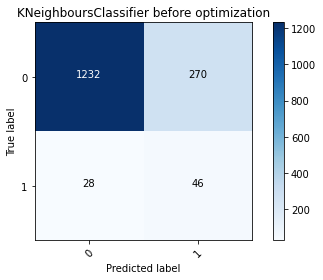

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1502
           1       0.15      0.62      0.24        74

    accuracy                           0.81      1576
   macro avg       0.56      0.72      0.56      1576
weighted avg       0.94      0.81      0.86      1576



In [67]:
#Best Model
labels = [0,1]
knn_estimator = KNeighborsClassifier(n_neighbors=10)
pipeline = Pipeline([("balancing", balancer_under),("classification", knn_estimator)])
pipeline.fit(thirdyearfeat_train_imp_03,thirdyearclass_train)
knn_preds = pipeline.predict(thirdyearfeat_test_imp_03)
f2_score_under=(getf2(thirdyearclass_test, knn_preds))
print(f"The F2 score with underbalancing is: {f2_score_under} ")

#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test, knn_preds)
#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='KNeighboursClassifier before optimization')
print(sklearn.metrics.classification_report(thirdyearclass_test, knn_preds))

## Neural Network

In [68]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from imblearn.pipeline import Pipeline
import keras
from sklearn.model_selection import KFold 
import numpy as np
from keras.layers import Dropout
from keras.constraints import maxnorm
# define the keras model
model = Sequential()
model.add(Dense(128, input_dim=64, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#pipeline used for balancing the different datasets
#best settings where chosen by an evolutionary approach
pipeline = Pipeline([("balancing", balancer_over)])
weights= {'0':1, '1':25}
x_resampled, x_labels_resampled = pipeline.fit_resample(thirdyearfeat_train, thirdyearclass_train)
model.fit(thirdyearfeat_train, thirdyearclass_train, validation_data=(thirdyearfeat_train, thirdyearclass_train), class_weight=weights, epochs=50, batch_size=8)

Train on 8927 samples, validate on 8927 samples
Epoch 1/50
8927/8927 [==============================] - 5s 553us/step - loss: 1.5358 - accuracy: 0.5346 - val_loss: 0.7235 - val_accuracy: 0.4054
Epoch 2/50
8927/8927 [==============================] - 4s 501us/step - loss: 1.4320 - accuracy: 0.4509 - val_loss: 0.7156 - val_accuracy: 0.5184
Epoch 3/50
8927/8927 [==============================] - 4s 493us/step - loss: 1.3673 - accuracy: 0.5287 - val_loss: 0.7117 - val_accuracy: 0.5291
Epoch 4/50
8927/8927 [==============================] - 4s 498us/step - loss: 1.3355 - accuracy: 0.5472 - val_loss: 0.7358 - val_accuracy: 0.5236
Epoch 5/50
8927/8927 [==============================] - 5s 504us/step - loss: 1.3095 - accuracy: 0.5580 - val_loss: 0.7442 - val_accuracy: 0.5129
Epoch 6/50
8927/8927 [==============================] - 5s 516us/step - loss: 1.2960 - accuracy: 0.5588 - val_loss: 0.7109 - val_accuracy: 0.5527
Epoch 7/50
8927/8927 [==============================] - 5s 507us/step - loss

0.7471020638959569
0.4032258064516128


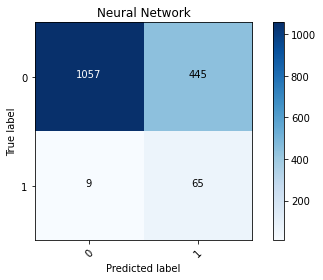

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1502
           1       0.13      0.88      0.22        74

    accuracy                           0.71      1576
   macro avg       0.56      0.79      0.52      1576
weighted avg       0.95      0.71      0.80      1576



In [69]:
mlp_preds = model.predict_classes(thirdyearfeat_test)
mlp_preds = mlp_preds.flatten()

print(fbeta_score(thirdyearclass_test.astype(int), mlp_preds, average=None, beta=2)[0])
print(fbeta_score(thirdyearclass_test.astype(int), mlp_preds, average=None, beta=2)[1])

labels = [0,1]

#compute the confusion matrix
cnf_matrix = confusion_matrix(thirdyearclass_test.astype(int), mlp_preds)
#print(cnf_matrix)

#plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes = labels, title='Neural Network')

print(sklearn.metrics.classification_report(thirdyearclass_test.astype(int), mlp_preds))

## Decision Tree - Rules analysis

F2 score w/o balancing: 0.1923076923076923
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06903272 0.         0.         0.
 0.         0.02503024 0.14543465 0.         0.         0.
 0.         0.         0.         0.46472594 0.         0.
 0.         0.         0.         0.         0.         0.01294809
 0.         0.         0.         0.04841046 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.23441791 0.         0.         0.         0.
 0.         0.         0.         0.        ]
1.0


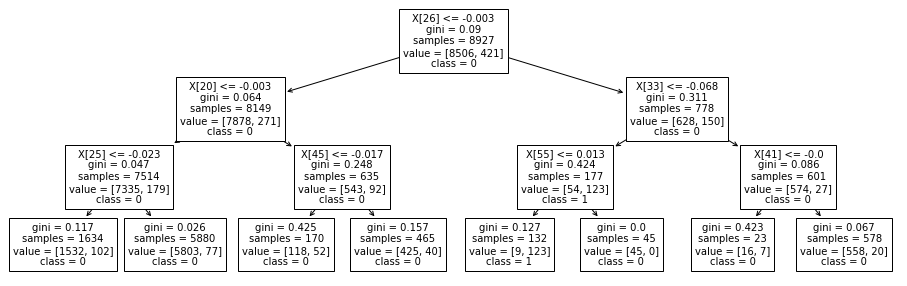

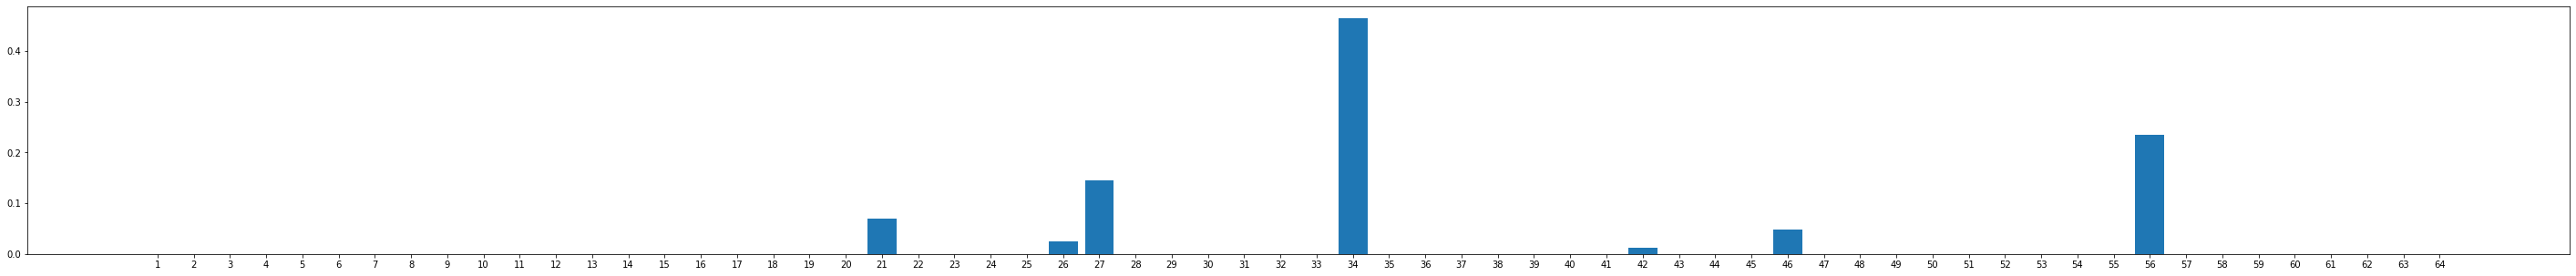

In [70]:
#for the report, unnormalized values were taken for better domain understanding

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

cn = ['0','1']
clf = DecisionTreeClassifier(max_depth = 3, random_state = 0)


pipeline1 = Pipeline([("classification", clf)])
pipeline1.fit(thirdyearfeat_train, thirdyearclass_train)
bankrupt_predict_thirdyear = pipeline1.predict(thirdyearfeat_test)

print(f"F2 score w/o balancing: {fbeta_score(thirdyearclass_test, bankrupt_predict_thirdyear, average=None, beta=2)[1]}")
fig, ax = plt.subplots(figsize=(16, 5))
tree.plot_tree(clf, class_names=cn, fontsize=10, max_depth=3)


importance = clf.feature_importances_
print(importance)
print(importance.sum())
f, ax = plt.subplots(figsize=(50,5))
plt.bar([x[4:6] for x, y in thirdyearfeat_train.iteritems()], importance, width=0.8)
plt.show()
